# Fundamentals of Machine Learning - 2022
## Report 2 - Classifying with convnets
Pablo Chehade  
Última modificación: 30/09/2022


### Introducción
El objetivo es aprender a utilizar redes neuronales convolucionales. Para tal fin se atacó un problema de clasificación de imágenes. En primer lugar, se entrenó un modelo base que servirá de comparación. Este consiste en Random Forest junto a un algoritmo de reducción de dimensionalidad. En segundo lugar, un modelo de redes convolucionales.

Se empleó "accuracy" como estimador del error. Es importante destacar que no siempre esta es la mejor opción. Dependiendo del objetivo del modelo quizás sea útil tener más precisión u otras características y se deberían emplear otros estimadores de error como "precision" o "recall". Incluso, "accuracy" no suele ser útil para problemas con class imbalance. En base a que el objetivo del modelo no fue estrictamente definido y que todas las clases tienen la misma cantidad de elementos, como se verificará próximamente, se optó sólo "accuracy" como estimador del error.

En primer lugar, se realizó un análisis exploratorio de los datos, verificando que no hay class imbalance. En segundo lugar, se dividieron los datos entre train_set y test_set empleando stratified sampling, de modo de asegurarse que haya la misma proporción de cada categoría en cada partición. En tercer lugar, se entrenó un modelo random forest. Se verificó además el efecto de emplear k-means como algoritmo de reducción de dimensionalidad. También se observó el efecto de aumentar la cantidad de datos a través de técnicas de data augmentation. En cuarto lugar, se entrenó un modelo de redes convolucionales empleando keras y se comparó con el modelo anterior.

### 

In [ ]:
#Importo librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import keras

from sklearn.metrics import accuracy_score

### Análisis Exploratorio de los Datos

#### Cargo los datos

In [366]:
import pickle
archivo = "datasets/faces_dict.p"
datos = pickle.load(open(archivo, 'rb'))

# infile = open(filename,'rb')
# new_dict = pickle.load(infile)
# infile.close()

#### Observo datos
Es importante verificar cuántos datos hay en total, cuántos de cada clase y en qué formato se encuentran. Esto último es importante porque será necesario adaptar el formato de los datos al necesario para cada modelo implementado.

In [367]:
print("Labels del diccionario datos: ", datos.keys())
print("Tamaño de cada label: ")
print("data: ", len(datos['data']), ", con elementos de tamaño ", len(datos['data'][0]))
print("images: ", len(datos['images']), ", con elementos de tamaño ", len(datos['images'][0]), "cada elemento de tamaño", len(datos['images'][0][0]))
print("target: ", len(datos['target']))

#Veamos cuántos elementos distintos hay en target
print(np.bincount(datos['target']))


Labels del diccionario datos:  dict_keys(['data', 'images', 'target'])
Tamaño de cada label: 
data:  400 , con elementos de tamaño  4096
images:  400 , con elementos de tamaño  64 cada elemento de tamaño 64
target:  400
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]


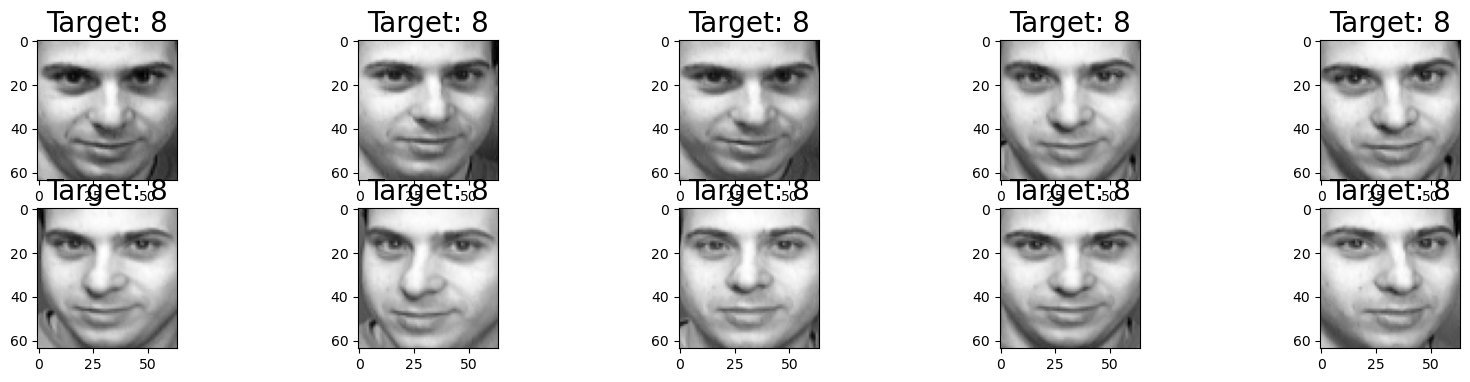

In [368]:
#Grafico algunos elementos de 'data'
#Se grafican de a 10 elementos accedidos mediante el índice k.

plt.figure(figsize=(20,4))
grid_rows = 2 #nro de filas en el grid de imágenes
grid_cols = 5 #nro de columnas en el grid de imágenes
grid_images = grid_rows*grid_cols #nro de imágenes a graficar
k = 8 #índice

for index, (image, label) in enumerate(zip(datos['data'][grid_images*k:grid_images*(k+1)], datos['target'][grid_images*k:grid_images*(k+1)])):
    plt.subplot(grid_rows, grid_cols, index + 1)
    plt.imshow(image.reshape(64,64), cmap=plt.cm.gray)
    plt.title('Target: %i' % label, fontsize = 20)


##### Observaciones
El .pickle es un diccionario con 3 labels: 'data', 'images' y 'target'
* En 'data' hay 400 elementos que representan las imágenes como arrays de 4096 (64x64). Se observa que las imágenes se encuentran ordenadas. 10 elementos consecutivos corresponen a la misma persona (mismo target)
* En 'images' hay 400 elementos que representan cada uno una matriz de 64x64 (imagen)
* En 'target' están los tags de las personas

Se observa entonces que hay 400 datos y 40 clases cada una con la misma cantidad de datos (no hay class imbalance)

### Data augmentation 
A priori 400 datos podrían parecer pocos, especialmente considerando que los modelos seleccionados necesitan una gran cantidad de datos para su entrenamiento. En base a esto se utiliza data augmentation que permite aumentar el tamaño del set de train generando variantes de cada dato. En teoría, esto ayudaría a disminuir el overfitting. A continuación una función que implementa data augmentation a través de dos técnicas:
* Flip vertical: se refleja la imagen a través de un eje vertical
* Random brightness: se ajusta el brightness de forma random

A continuación se ejecuta un ejemplo de uso de estas técnicas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Bright')

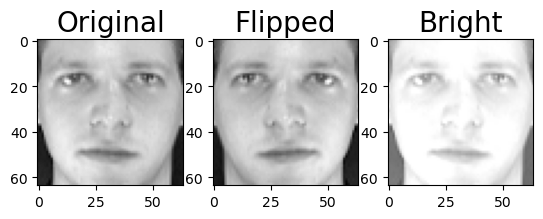

In [509]:

original = datos['images'][0]
plt.subplot(1,3,1)
plt.imshow(original, cmap=plt.cm.gray)
plt.title('Original', fontsize = 20)

new = tf.convert_to_tensor(original.reshape((*original.shape, 1))) #primero es necesario que la imagen tenga size (64,64,1) para que tensorflow pueda procesarla
new = tf.image.grayscale_to_rgb(new) #convertimos a RGB para poder utilizar las técnicas de data augmentation

original_flipped = tf.image.rgb_to_grayscale(tf.image.flip_left_right(new)) #flip left right y vuelvo a escala de grises
plt.subplot(1,3,2)
plt.imshow(original_flipped, cmap=plt.cm.gray)
plt.title('Flipped', fontsize = 20)

# original_cropped = tf.image.rgb_to_grayscale(tf.image.random_crop(new, size = [64,64,3])) #crop central
# plt.subplot(1,4,3)
# plt.imshow(original_cropped, cmap=plt.cm.gray)
# plt.title('Cropped', fontsize = 20)

original_bright = tf.image.random_brightness(new, max_delta=0.5)
plt.subplot(1,3,3)
plt.imshow(original_bright, cmap=plt.cm.gray)
plt.title('Bright', fontsize = 20)


In [609]:
def data_augmentation(original):
    new = tf.convert_to_tensor(original.reshape((*original.shape, 1))) #primero es necesario que la imagen tenga size (64,64,1) para que tensorflow pueda procesarla
    new = tf.image.grayscale_to_rgb(new) #convertimos a RGB para poder utilizar las técnicas de data augmentation

    original_flipped = tf.image.rgb_to_grayscale(tf.image.flip_left_right(new)) #flip left right y vuelvo a escala de grises
    original_bright = tf.image.rgb_to_grayscale(tf.image.random_brightness(new, max_delta=0.5)) #random brightness y vuelvo a escala de grises
    return tf.make_ndarray(tf.make_tensor_proto(original_flipped)), tf.make_ndarray(tf.make_tensor_proto(original_bright)) #Para devolverlos como numpy ndarrays (como estaban originalmente)

# a, b = data_augmentation(datos['images'][0])
# len(a.flatten())/64

### MODELO 1: Random Forest

La elección de este modelo se basa en que el entrenamiento es relativamente rápido

En primer lugar, se hará una separación entre train y test. En segundo lugar, se evaluará en un modelo sencillo el efecto de usar k-means, data augmentation y ambos al mismo tiempo. ¿Por qué sería útiles emplear estas técnicas? Solo se cuenta con 400 datos y 64*64 = 4096 variables. La cantidad de datos frente a la dimensión de los mismos es insignificante por lo que a priori parece que podrían ser útiles algún algoritmo para reducir las dimensiones y otro para aumentar la cantidad de datos. En tercer y último lugar se aplicará grid search junto a cross validation para optimizar los hiperparámetros del modelo.


In [522]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    #función para presentar los resultados 
    print("Scores:", scores) #Score de cada partición
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

#### Separo entre train y test

El objetivo del modelo es, dada una foto de una persona que ya se encuentra en el dataset, ser capaz de predecir a qué target pertenece (quién es). Entonces, podemos elegir de forma inteligente el set de train. Si lo hacemos aleatoriamente podríamos caer en un situación en la que haya muy pocas imágenes de una persona en el set de train y gran parte en el test o, aún peor, que todas las imágenes de una persona se encuentren en el test! Para evitar esto se puede hacer "stratified samping"

BUSCAR QUÉ ES stratified sampling 

En base a esto, el set de test no será elegido aleatoriamente sobre todos los datos, sino sobre los datos de cada target. Por ejemplo, si el set de test cuenta con el 20% de los datos, esto significa que de cada persona elegiremos aleatoriamente 2 imágenes para el set de test.

POR QUÉ NO ESTOY HACIENDO ESTO EN EL SET DE VALIDACIÓN?

In [631]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(datos['data'], datos['target']):
    train_predictors, test_predictors = datos['data'][train_index], datos['data'][test_index]
    train_target, test_target = datos['target'][train_index], datos['target'][test_index]

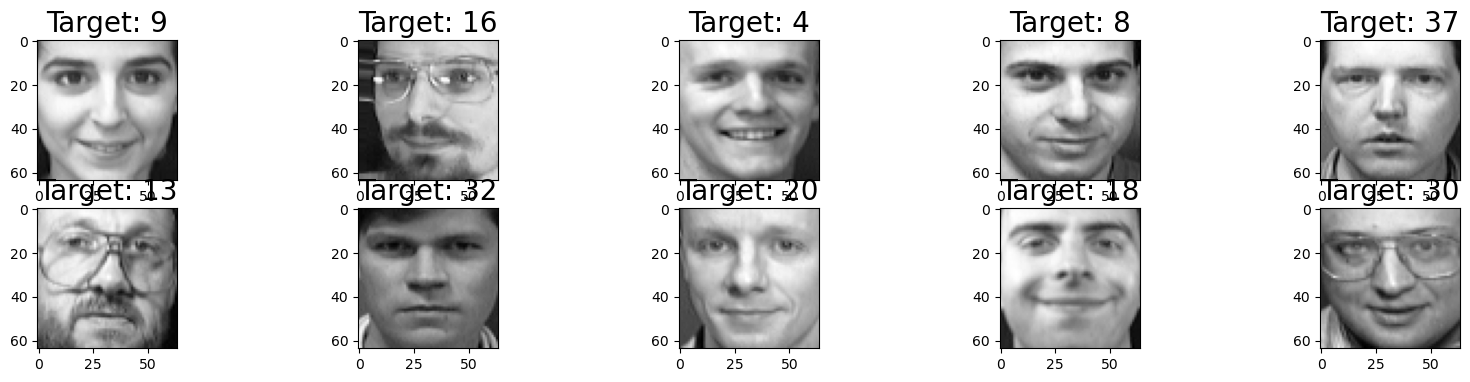

In [632]:
#Verificación
plt.figure(figsize=(20,4))
grid_rows = 2 #nro de filas en el grid de imágenes
grid_cols = 5 #nro de columnas en el grid de imágenes
grid_images = grid_rows*grid_cols #nro de imágenes a graficar
k = 5 #índice

for index, (image, label) in enumerate(zip(test_predictors[grid_images*k:grid_images*(k+1)], test_target[grid_images*k:grid_images*(k+1)])):
    plt.subplot(grid_rows, grid_cols, index + 1)
    plt.imshow(image.reshape(64,64), cmap=plt.cm.gray)
    plt.title('Target: %i' % label, fontsize = 20)


In [633]:
#Veamos si efectivamente hay 2 elementos de cada clase en el conjunto de test
print(np.bincount(test_target))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]


#### Modelo simple

Creo un modelo con los parámetros por default salvo max_depth y hago cross-validation con cv = 5. Por default la variable max_depth está en None, es decir, los nodos se expanden hasta que las leaves sean puras e implica rápidamente overfitting. 

In [634]:
#Copio datos
RFtrain_predictors = train_predictors.copy()
RFtrain_target = train_target.copy()
RFtest_predictors = test_predictors.copy()
RFtest_target = test_target.copy()

#Creo el modelo
RFmodel = RandomForestClassifier(n_jobs = -1, random_state = 42, max_depth = 10)
#Lo entreno
# RFmodel.fit(RFtrain_predictors, RFtrain_target)

#Hago cross-validation
scores = cross_val_score(RFmodel, RFtrain_predictors, RFtrain_target,scoring="accuracy", cv=5) #cv es la cantidad de particiones
display_scores(scores)

Scores: [0.921875 0.796875 0.828125 0.765625 0.78125 ]
Mean: 0.81875
Standard deviation: 0.055551215108222425


#### Modelo simple con K-MEANS

Varío el número de clusters k entre 10 y 50. A priori, se esperaría que haya 10 clusters solamente, pero podrían ser necesarios más para que el modelo logre un mejor desempeño

In [635]:
from sklearn.cluster import KMeans

def k_means(k, train_predictors, test_predictors):
    #Construye los clusters a partir de train_predictors y calcula las distancias a cada cluster para los elementos de train_predictors y test_predictors
    #De este modo, los datos pasan de dimensión 64x64 = 4096 a dimensión k
    #k: sé a priori la cantidad de clusters que esperaría ver. Podría poner un valor más alto pero considerando que por cada cluster habrá una nueva clase para el modelo de clasificación, mejor ser conservador. Técnicamente k es un hiperparámetro que habría que variar en el gridsearch.
    kmeans = KMeans(n_clusters=k, random_state=42)
    train_kdist = kmeans.fit_transform(train_predictors) #Construye los clusters y calcula las distancias a cada cluster
    test_kdist = kmeans.transform(test_predictors) #Calcula la distancia entre una imagen de test_predictors y todos los clusters anteriores (no hay un entrenamiento con estos nuevos datos). Esto será importante para evaluar al final el error del modelo
    return train_kdist, test_kdist

In [636]:
k_array = [10, 15, 20, 30, 50]
for k in k_array:
    #Aplico k-means
    train_kdist, test_kdist = k_means(k, train_predictors, test_predictors)

    #Copio datos
    RFtrain_predictors = train_kdist.copy()
    RFtrain_target = train_target.copy()
    RFtest_predictors = test_kdist.copy()
    RFtest_target = test_target.copy()

    #Creo el modelo
    RFmodel = RandomForestClassifier(n_jobs = -1, random_state = 42, max_depth = 10)
    # #Lo entreno
    # RFmodel.fit(RFtrain_predictors, RFtrain_target)

    #Hago cross-validation
    scores = cross_val_score(RFmodel, RFtrain_predictors, RFtrain_target,scoring="accuracy", cv=5) #cv es la cantidad de particiones
    print("\nk = ", k)
    display_scores(scores)



k =  10
Scores: [0.578125 0.640625 0.609375 0.59375  0.515625]
Mean: 0.5875
Standard deviation: 0.0414578098794425

k =  15
Scores: [0.6875   0.609375 0.65625  0.65625  0.640625]
Mean: 0.65
Standard deviation: 0.025387620014487376

k =  20
Scores: [0.75     0.625    0.71875  0.609375 0.640625]
Mean: 0.66875
Standard deviation: 0.05537514108334172

k =  30
Scores: [0.734375 0.703125 0.734375 0.703125 0.6875  ]
Mean: 0.7125
Standard deviation: 0.018750000000000003

k =  50
Scores: [0.8125   0.6875   0.8125   0.765625 0.75    ]
Mean: 0.765625
Standard deviation: 0.046351240544347895


#### Modelo simple con Data augmentation

In [637]:
#Aplico data_augmentation a cada imagen del set de train y creo el set de train aumentado

# def asignacion(a,b,n):
#     #asigna los elementos de b a los de a, de a[0] a a[n-1]
#     for i in range(n):
#         a[i] = b[i]



data_aug = []
images_aug = []
target_aug = []
for i in range(len(train_predictors)):
    image = train_predictors[i].reshape(64,64)
    flipped, bright = data_augmentation(image)
    flipped, bright = flipped[:,:,0], bright[:,:,0] #elimino el último índice
    data_aug.append(image.flatten())
    data_aug.append(flipped.flatten())
    data_aug.append(bright.flatten())
    images_aug.append(image)
    images_aug.append(flipped)
    images_aug.append(bright)
    target_aug.append(train_target[i])
    target_aug.append(train_target[i])
    target_aug.append(train_target[i])



#Creo el diccionario
datos_aug = {'data': data_aug, 'images': images_aug, 'target': target_aug}

#Exporto como .p
pickle.dump(datos_aug, open("datasets/faces_dict_train_aug.p", "wb"))

In [638]:
#Cargo los datos
datos_aug = pickle.load(open("datasets/faces_dict_train_aug.p", "rb"))

#Copio datos
RFtrain_predictors = datos_aug['data'].copy()
RFtrain_target = datos_aug['target'].copy()
RFtest_predictors = test_predictors.copy()
RFtest_target = test_target.copy()

#Creo el modelo
RFmodel = RandomForestClassifier(n_jobs = -1, random_state = 42, max_depth = 10)
# #Lo entreno
# RFmodel.fit(RFtrain_predictors, RFtrain_target)

#Hago cross-validation
scores = cross_val_score(RFmodel, RFtrain_predictors, RFtrain_target,scoring="accuracy", cv=5) #cv es la cantidad de particiones
display_scores(scores)

Scores: [0.80208333 0.66666667 0.765625   0.71875    0.66666667]
Mean: 0.7239583333333333
Standard deviation: 0.05372415399261514


#### Modelo simple con K-MEANS y Data augmentation

In [639]:
#Cargo el .p
datos_train_aug = pickle.load(open("datasets/faces_dict_train_aug.p", "rb"))

#Copio datos
RFtrain_predictors = datos_aug['data'].copy()
RFtrain_target = datos_aug['target'].copy()
RFtest_predictors = test_predictors.copy()
RFtest_target = test_target.copy()

k_array = [10, 15, 20, 30, 50]
for k in k_array:
    #Aplico k-means
    train_kdist, test_kdist = k_means(k, train_predictors, test_predictors)

    #Copio datos
    RFtrain_predictors = train_kdist.copy()
    RFtrain_target = train_target.copy()
    RFtest_predictors = test_kdist.copy()
    RFtest_target = test_target.copy()

    #Creo el modelo
    RFmodel = RandomForestClassifier(n_jobs = -1, random_state = 42, max_depth = 10)
    # #Lo entreno
    # RFmodel.fit(RFtrain_predictors, RFtrain_target)

    #Hago cross-validation
    scores = cross_val_score(RFmodel, RFtrain_predictors, RFtrain_target,scoring="accuracy", cv=5) #cv es la cantidad de particiones
    print("\nk = ", k)
    display_scores(scores)



k =  10
Scores: [0.578125 0.640625 0.609375 0.59375  0.515625]
Mean: 0.5875
Standard deviation: 0.0414578098794425

k =  15
Scores: [0.6875   0.609375 0.65625  0.65625  0.640625]
Mean: 0.65
Standard deviation: 0.025387620014487376

k =  20
Scores: [0.75     0.625    0.71875  0.609375 0.640625]
Mean: 0.66875
Standard deviation: 0.05537514108334172

k =  30
Scores: [0.734375 0.703125 0.734375 0.703125 0.6875  ]
Mean: 0.7125
Standard deviation: 0.018750000000000003

k =  50
Scores: [0.8125   0.6875   0.8125   0.765625 0.75    ]
Mean: 0.765625
Standard deviation: 0.046351240544347895


##### Observaciones

Accuracy de los distintos modelos:
1. Modelo simple: 0.82 +/- 0.06
2. Modelo simple + k-means:
* k =  10: 0.59 +/- 0.05
* k =  15: 0.65 +/- 0.03
* k =  20: 0.67 +/- 0.06
* k =  30: 0.71 +/- 0.02
* k =  50: 0.77 +/- 0.05
3. Modelo simple + data augmentation: 0.7239583333333333 +/- 0.05372415399261514
4. Modelo simple + data augmentation + k-means:
* k =  10: 0.59 +/- 0.05
* k =  15: 0.65 +/- 0.03
* k =  20: 0.67 +/- 0.06
* k =  30: 0.71 +/- 0.02
* k =  50: 0.77 +/- 0.05

Sorprendentemente el modelo simple sin k-means y sin data augmentation tiene mejor desempeño que los demás. A priori no es claro por qué es así, habría que estudiar con mayor detalle este resultado. Quizás se deba a que la comparación no es del todo justa dado que se están comparando todos los modelos con los mismos hiperparámetros. La comparación más justa sería con la mejor elección de hiperparámetros para cada modelo. Formalmente, se debe continuar el análisis con el modelo más sencillo dado que tiene menor error.

#### Grid Search

En el práctico anterior se discutió este modelo con detalle, junto a los parámetros que se pueden variar. En este caso se decidió variar:
1. n_estimators: nro de trees en el forest  
* Default: 100  
* Variación: 10 a 200
2. criterion: función para medir el error en el split
* Default: "gini"  
* Variación: ["gini", "entropy", "log_loss"]  
3. max_depth: máxima depth en el tree
* Default = None, es decir, los nodos se expanden hasta que todas las leaves sean puras  
* Variación: 1 a 100
4. min_samples_split: nro minimo de samples necesarios para hacer un split en un nodo interno
* Default: 2
* Variación: 1 a 10
5. min_samples_leaf: nro mínimo de samples necesario para estar en un leaf node.
* Default: 1
* Variación: 1 a 20
6. max_features: nro de atributos considerados al buscar el mejor split. Sea p la cantidad total de variables.
* Default: sqrt(p)
* Variación: ["sqrt", "log2"]

In [381]:
#Tengo que poner que me devuelva el error de test para cada entrenamiento del modelo

from sklearn.model_selection import GridSearchCV

#Defino los parámetros a variar:
n_stimators_list = [1,2,4,10,20,80,160]
criterion_list = ["gini"]  
max_depth_list = [1,2,4,10,20,60]
min_samples_split_list = [1,2,4,8]
min_samples_leaf_list = [1,2,4,8]
max_features_list = ["sqrt", "log2"]

param_grid = [
    {'n_estimators': n_stimators_list, 'criterion': criterion_list,  'max_depth': max_depth_list, 'min_samples_split':min_samples_split_list, 'min_samples_leaf':min_samples_leaf_list, 'max_features': max_features_list, 'oob_score':[True]},
  ]

# param_grid = [
#   {'n_estimators': [100], 'criterion':["entropy"],  'max_depth':[20, 40, 60, 100], 'min_samples_split':[2, 8], 'min_samples_leaf':[1, 4], 'max_features':["sqrt"], 'oob_score':[True]},
# ]

#Defino el modelo
RFmodel_GS = RandomForestClassifier(n_jobs = -1, random_state=42, oob_score = True)

grid_search = GridSearchCV(RFmodel_GS, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose = 3); #verbose muestra el progreso a medida que se hace el gridsearch. A mayor valor, más info da. El máximo es 3. Es útil cuando tengo que hacer corridas largas.
grid_search.fit(RFtrain_predictors, RFtrain_target)


Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1, oob_score=True;, score=(train=nan, test=nan) total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1, oob_score=True;, score=(train=nan, test=nan) total time=   1.7s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1, oob_score=True;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1, oob_score=True;, score=(train=nan, test=nan) total time=   1.6s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1, oob_score=True;, score=(train=nan, test=nan) total time=   1.7s
[CV 1/5] END criterion=gi

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.047) total time=   1.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.031) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.078) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.238, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.094) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.238, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.156) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.094) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.238, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.156) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.047) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.031) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.078) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.238, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.094) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.238, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.156) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.094) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.238, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.156) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.047) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.031) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.078) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.238, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.031) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.094) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.238, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.156) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.094) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.238, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.184, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.156) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.047) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.074, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.078, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.109, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.113, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.195, test=0.109) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.211, test=0.188) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.195, test=0.109) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.074, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.078, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.062) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.109, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.113, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.195, test=0.109) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.211, test=0.188) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.195, test=0.109) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.074, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.078, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.109, test=0.062) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.113, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.195, test=0.109) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.211, test=0.188) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.195, test=0.109) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.164, test=0.172) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.016) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.043, test=0.016) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.059, test=0.047) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.090, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.211, test=0.109) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.125) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.172) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.043, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.059, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.090, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.211, test=0.109) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.125) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.172) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.043, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.059, test=0.047) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.090, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.211, test=0.109) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.125) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.172) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.016) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.043, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.059, test=0.047) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.090, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.211, test=0.109) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.125) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.172) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.043, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.059, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.090, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.211, test=0.109) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.125) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.172) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.043, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.059, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.090, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.211, test=0.109) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.188, test=0.125) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.172) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.016) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.043, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.059, test=0.047) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.090, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.199, test=0.109) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.176, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.172) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.168, test=0.094) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.043, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.059, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.090, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.199, test=0.109) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.176, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.172) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.168, test=0.094) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.043, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.039, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.059, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.090, test=0.078) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.199, test=0.109) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.176, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.215, test=0.172) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.074, test=0.078) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.047) total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.078, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.125, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.113, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.180, test=0.078) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.168, test=0.125) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.246, test=0.188) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.227, test=0.188) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.074, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.047) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.078, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.125, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.113, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.180, test=0.078) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.168, test=0.125) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.246, test=0.188) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.227, test=0.188) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.047, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.051, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.016) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.074, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.070, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.078, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.082, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.125, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.098, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.113, test=0.078) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.105, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.180, test=0.078) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.168, test=0.125) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.246, test=0.188) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.227, test=0.188) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.047) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.059, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.148, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.172, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.180, test=0.125) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.191, test=0.141) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.316, test=0.203) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.312) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.293, test=0.219) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.059, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.148, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.172, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.180, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.191, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.316, test=0.203) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.312) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.293, test=0.219) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.281, test=0.234) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.059, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.145, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.172, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.172, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.191, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.336, test=0.203) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.316, test=0.281) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.289, test=0.219) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.285, test=0.234) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.047) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.059, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.148, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.172, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.180, test=0.125) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.191, test=0.141) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.312, test=0.203) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.324, test=0.312) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.293, test=0.219) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.059, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.148, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.172, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.180, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.191, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.312, test=0.203) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.324, test=0.312) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.293, test=0.219) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.277, test=0.234) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.059, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.145, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.172, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.172, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.191, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.336, test=0.203) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.316, test=0.281) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.289, test=0.219) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.285, test=0.234) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.047) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.090, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.059, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.141, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.172, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.168, test=0.125) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.191, test=0.141) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.316, test=0.281) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.289, test=0.219) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.090, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.059, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.141, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.172, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.168, test=0.125) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.191, test=0.141) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.316, test=0.281) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.289, test=0.219) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.055, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.090, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.059, test=0.031) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.062) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.141, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.172, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.168, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.191, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.316, test=0.281) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.289, test=0.219) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.289, test=0.234) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.070, test=0.047) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.062, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.094) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.062) total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.141, test=0.094) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.137, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.180, test=0.141) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.160, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.188, test=0.125) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.141) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.301, test=0.234) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.270, test=0.188) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.250) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.277, test=0.172) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.062, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.047) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.141, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.137, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.180, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.160, test=0.094) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.188, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.125) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.301, test=0.234) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.270, test=0.188) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.250) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.277, test=0.172) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.273, test=0.172) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.062, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.062, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.070, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.117, test=0.047) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.141, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.137, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.180, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.160, test=0.094) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.188, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.125) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.301, test=0.234) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.270, test=0.188) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.250) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.277, test=0.172) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.273, test=0.172) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.047) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.090, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.133, test=0.094) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.094) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.125) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.164, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.188, test=0.094) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.344, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.344, test=0.266) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.324, test=0.172) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.090, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.133, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.047) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.125) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.164, test=0.109) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.188, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.332, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.344, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.344, test=0.266) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.324, test=0.172) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.297, test=0.172) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.090, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.133, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.094) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.047) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.125) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.176, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.156, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.164, test=0.109) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.188, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.324, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.309, test=0.219) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.297, test=0.234) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.316, test=0.156) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.297, test=0.172) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.047) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.090, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.047) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.133, test=0.094) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.094) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.125) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.191, test=0.156) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.164, test=0.109) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.188, test=0.094) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.328, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.340, test=0.234) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.340, test=0.281) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.324, test=0.172) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.090, test=0.062) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.047) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.133, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.094) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.125) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.191, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.164, test=0.109) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.188, test=0.094) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.328, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.340, test=0.234) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.340, test=0.281) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_sa

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.090, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.133, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.129, test=0.047) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.203, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.176, test=0.109) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.156, test=0.109) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.164, test=0.109) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.188, test=0.094) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.324, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.309, test=0.219) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.297, test=0.234) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_sa

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.074, test=0.047) total time=   1.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.086, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.133, test=0.094) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.094) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.176, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.156, test=0.109) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.164, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.168, test=0.094) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.336, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.336, test=0.250) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.293, test=0.234) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.316, test=0.156) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.086, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.133, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.176, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.156, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.164, test=0.109) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.168, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.336, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.336, test=0.250) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.293, test=0.234) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.316, test=0.156) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.254, test=0.141) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.086, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.066, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.133, test=0.094) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.094, test=0.062) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.223, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.176, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.156, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.164, test=0.109) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.168, test=0.094) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.336, test=0.188) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.336, test=0.250) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.293, test=0.234) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.316, test=0.156) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.254, test=0.141) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.062) total time=   1.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.070, test=0.016) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.062) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.125) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.047) total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.062) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.152, test=0.109) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.016) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.211, test=0.156) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.141, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.141, test=0.094) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.207, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.168, test=0.094) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.336, test=0.203) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.246, test=0.172) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.359, test=0.297) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.293, test=0.141) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.070, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.125) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.062) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.152, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.016) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.211, test=0.156) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.141, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.141, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.207, test=0.141) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.168, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.336, test=0.203) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.246, test=0.172) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.359, test=0.297) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.293, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.281, test=0.141) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.070, test=0.016) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.082, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.078, test=0.062) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.082, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.125) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.121, test=0.047) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.109, test=0.062) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.152, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.102, test=0.016) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.211, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.141, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.141, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.207, test=0.141) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.168, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.336, test=0.203) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.246, test=0.172) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.359, test=0.297) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.293, test=0.141) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.281, test=0.141) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.094) total time=   1.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.105, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.148, test=0.094) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.113, test=0.047) total time=   0.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.234, test=0.109) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.242, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.172) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.254, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.340, test=0.219) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.355, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.332, test=0.203) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.293, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.371, test=0.156) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.562, test=0.312) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.453, test=0.375) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.527, test=0.406) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.531, test=0.328) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.105, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.148, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.113, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.234, test=0.109) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.242, test=0.094) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.172) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.254, test=0.078) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.340, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.355, test=0.250) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.340, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.293, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.371, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.551, test=0.312) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.426, test=0.328) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.516, test=0.406) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.520, test=0.328) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.523, test=0.328) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.113, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.215, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.219, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.211, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.336, test=0.203) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.344, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.305, test=0.188) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.273, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.336, test=0.172) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.535, test=0.312) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.434, test=0.344) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.477, test=0.328) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.484, test=0.344) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.094) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.141, test=0.094) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.113, test=0.047) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.230, test=0.125) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.230, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.203, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.242, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.332, test=0.219) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.355, test=0.250) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.328, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.285, test=0.156) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.359, test=0.188) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.543, test=0.312) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.426, test=0.328) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.520, test=0.391) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.520, test=0.328) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.141, test=0.094) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.113, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.230, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.230, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.203, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.242, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.332, test=0.219) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.355, test=0.250) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.328, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.285, test=0.156) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.359, test=0.188) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.543, test=0.312) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.426, test=0.328) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.520, test=0.391) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_sa

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.113, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.215, test=0.125) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.219, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.211, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.078) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.336, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.344, test=0.234) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.305, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.273, test=0.188) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.336, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.535, test=0.312) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.434, test=0.344) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.477, test=0.328) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.484, test=0.344) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.477, test=0.312) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.109) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.4s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.113, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.215, test=0.141) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.223, test=0.078) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.211, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.320, test=0.203) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.344, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.301, test=0.188) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.297, test=0.234) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.328, test=0.172) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.531, test=0.297) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.434, test=0.359) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.477, test=0.328) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.469, test=0.391) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.113, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.215, test=0.141) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.223, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.211, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.078) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.320, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.344, test=0.234) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.301, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.297, test=0.234) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.328, test=0.172) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.531, test=0.297) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.434, test=0.359) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.477, test=0.328) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.469, test=0.391) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.457, test=0.312) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.098, test=0.031) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.113, test=0.047) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.125, test=0.047) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.215, test=0.141) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.223, test=0.078) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.211, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.078) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.320, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.344, test=0.234) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.301, test=0.188) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.297, test=0.234) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.328, test=0.172) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.531, test=0.297) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.434, test=0.359) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.477, test=0.328) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.469, test=0.391) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.457, test=0.312) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.113, test=0.094) total time=   1.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.125) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.141, test=0.094) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.164, test=0.125) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.172, test=0.094) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.191, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.234, test=0.172) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.203, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.340, test=0.234) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.316, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.309, test=0.266) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.344, test=0.203) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.340, test=0.234) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.484, test=0.344) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.555, test=0.328) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.547, test=0.422) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.535, test=0.250) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.141, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.164, test=0.125) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.172, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.191, test=0.109) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.234, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.203, test=0.094) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.340, test=0.234) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.316, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.309, test=0.266) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.344, test=0.203) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.340, test=0.234) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.484, test=0.344) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.555, test=0.328) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.547, test=0.422) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.535, test=0.250) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.105, test=0.047) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.109, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.141, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.164, test=0.125) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.172, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.191, test=0.109) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.234, test=0.172) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.203, test=0.094) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.340, test=0.234) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.316, test=0.188) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.309, test=0.266) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.344, test=0.203) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.340, test=0.234) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.484, test=0.344) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.555, test=0.328) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.547, test=0.422) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.535, test=0.250) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.516, test=0.328) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.109) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.164, test=0.125) total time=   0.4s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.137, test=0.094) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.137, test=0.078) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.199, test=0.156) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.230, test=0.125) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.246, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.211, test=0.141) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.238, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.324, test=0.203) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.410, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.379, test=0.250) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.375, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.387, test=0.203) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.469, test=0.250) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.582, test=0.312) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.570, test=0.422) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.570, test=0.281) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.156, test=0.141) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.137, test=0.078) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.199, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.230, test=0.125) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.270, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.211, test=0.141) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.227, test=0.094) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.324, test=0.203) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.395, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.398, test=0.328) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.375, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.379, test=0.188) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.461, test=0.250) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.582, test=0.312) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.594, test=0.484) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.570, test=0.281) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.141, test=0.125) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.164, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.137, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.238, test=0.219) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.203, test=0.172) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.219, test=0.109) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.227, test=0.094) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.355, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.375, test=0.219) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.328, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.363, test=0.203) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.355, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.441, test=0.250) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.547, test=0.344) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.547, test=0.344) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.555, test=0.281) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.469, test=0.281) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.109) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.156, test=0.125) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.156, test=0.141) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.137, test=0.078) total time=   0.4s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.219, test=0.125) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.266, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.211, test=0.141) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.227, test=0.094) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.324, test=0.203) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.391, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.391, test=0.328) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.371, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.371, test=0.188) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.453, test=0.266) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.566, test=0.328) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.598, test=0.484) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.566, test=0.297) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.156, test=0.125) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.156, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.137, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.195, test=0.156) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.219, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.266, test=0.219) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.211, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.227, test=0.094) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.324, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.391, test=0.203) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.391, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.371, test=0.219) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.371, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.453, test=0.266) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.566, test=0.328) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.598, test=0.484) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.566, test=0.297) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.539, test=0.328) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.141, test=0.125) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.164, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.137, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.238, test=0.219) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.203, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.219, test=0.109) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.227, test=0.094) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.355, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.375, test=0.219) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.320, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.363, test=0.203) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.355, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.441, test=0.250) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.547, test=0.344) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.539, test=0.344) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.555, test=0.281) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.469, test=0.281) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.109) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.125) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.160, test=0.109) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.137, test=0.078) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.242, test=0.156) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.172) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.219, test=0.109) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.141) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.270, test=0.156) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.387, test=0.203) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.379, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.320, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.395, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.375, test=0.250) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.512, test=0.266) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.586, test=0.344) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.562, test=0.359) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.539, test=0.266) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.125) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.160, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.137, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.242, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.172) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.219, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.141) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.270, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.387, test=0.203) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.379, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.320, test=0.203) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.395, test=0.203) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.375, test=0.250) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.512, test=0.266) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.586, test=0.344) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.562, test=0.359) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.539, test=0.266) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.125) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.160, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.133, test=0.078) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.137, test=0.078) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.242, test=0.156) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.219, test=0.109) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.207, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.270, test=0.156) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.387, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.379, test=0.203) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.320, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.395, test=0.203) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.375, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.512, test=0.266) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.586, test=0.344) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.562, test=0.359) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.539, test=0.266) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.496, test=0.266) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.188, test=0.125) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.109) total time=10.0min


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.121, test=0.094) total time=   1.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.141, test=0.031) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.246, test=0.188) total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.254, test=0.125) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.246, test=0.141) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.230, test=0.188) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.188, test=0.062) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.328, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.348, test=0.156) total time=   0.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.367, test=0.250) total time=   0.7s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.312, test=0.188) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.332, test=0.172) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.566, test=0.328) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.586, test=0.359) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.613, test=0.406) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.492, test=0.297) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_s

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.121, test=0.094) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.141, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.246, test=0.188) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.254, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.246, test=0.141) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.230, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.188, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.328, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.348, test=0.156) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.367, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.312, test=0.188) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.332, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.566, test=0.328) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.586, test=0.359) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.613, test=0.406) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.492, test=0.297) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.605, test=0.344) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.180, test=0.109) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.145, test=0.109) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.121, test=0.094) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.141, test=0.031) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.246, test=0.188) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.254, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.246, test=0.141) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.230, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.188, test=0.062) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.328, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.348, test=0.156) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.367, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.312, test=0.188) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.332, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.566, test=0.328) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.586, test=0.359) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.613, test=0.406) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.492, test=0.297) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.605, test=0.344) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=log2, min_

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.340, test=0.219) total time=   1.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.438, test=0.219) total time=   0.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.348, test=0.172) total time=   0.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.266, test=0.047) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.379, test=0.188) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.449, test=0.250) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.547, test=0.312) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.496, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.480, test=0.172) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.586, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.645, test=0.469) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.797, test=0.453) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.629, test=0.375) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.617, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.719, test=0.500) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.871, test=0.656) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.578) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.859, test=0.500) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.832, test=0.422) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.438, test=0.219) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.320, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.371, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.480, test=0.281) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.547, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.418, test=0.188) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.531, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.527, test=0.250) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.605, test=0.344) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.773, test=0.469) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.559, test=0.359) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.633, test=0.266) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.672, test=0.422) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.852, test=0.609) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.910, test=0.625) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.820, test=0.609) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, 

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.156) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.352, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.188) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.383, test=0.219) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.430, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.512, test=0.297) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.449, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.566, test=0.312) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.531, test=0.266) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.559, test=0.391) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.688, test=0.438) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.613, test=0.375) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.648, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.684, test=0.438) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.852, test=0.578) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.824, test=0.500) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.816, test=0.531) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.809, test=0.500) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.203) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.410, test=0.219) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.301, test=0.125) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.363, test=0.188) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.484, test=0.281) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.531, test=0.281) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.398, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.531, test=0.234) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.520, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.609, test=0.328) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.453) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.551, test=0.344) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.621, test=0.250) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.668, test=0.422) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.852, test=0.641) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.918, test=0.609) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.824, test=0.594) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.836, test=0.453) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.410, test=0.219) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.301, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.363, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.484, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.531, test=0.281) total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.398, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.531, test=0.234) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.520, test=0.250) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.609, test=0.328) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.453) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.551, test=0.344) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.621, test=0.250) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.668, test=0.422) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.852, test=0.641) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.918, test=0.609) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.824, test=0.594) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.836, test=0.453) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.156) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.352, test=0.172) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.188) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.383, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.430, test=0.203) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.512, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.449, test=0.203) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.566, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.531, test=0.266) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.559, test=0.391) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.688, test=0.438) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.613, test=0.375) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.648, test=0.312) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.684, test=0.438) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.852, test=0.578) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.824, test=0.500) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.816, test=0.531) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.809, test=0.500) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.824, test=0.625) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.188) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.348, test=0.125) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.305, test=0.156) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.125) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.477, test=0.266) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.469, test=0.312) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.395, test=0.219) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.551, test=0.312) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.473, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.562, test=0.344) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.703, test=0.500) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.543, test=0.422) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.648, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.625, test=0.328) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.641) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.859, test=0.531) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.852, test=0.625) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.812, test=0.562) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.348, test=0.125) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.305, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.125) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.477, test=0.266) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.469, test=0.312) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.395, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.551, test=0.312) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.473, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.562, test=0.344) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.703, test=0.500) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.543, test=0.422) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.648, test=0.344) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.625, test=0.328) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.641) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.859, test=0.531) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.852, test=0.625) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.812, test=0.562) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.305, test=0.156) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.125) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.477, test=0.266) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.469, test=0.312) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.395, test=0.219) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.551, test=0.312) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.473, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.562, test=0.344) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.703, test=0.500) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.543, test=0.422) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.648, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.625, test=0.328) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.641) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.859, test=0.531) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.852, test=0.625) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.812, test=0.562) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.219, test=0.172) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.172) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.277, test=0.141) total time=   0.4s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.254, test=0.094) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.262, test=0.141) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.367, test=0.266) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.480, test=0.250) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.395, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.445, test=0.234) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.438, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.672, test=0.500) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.660, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.582, test=0.453) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.566, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.695, test=0.484) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.887, test=0.688) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.516) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.883, test=0.625) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.891, test=0.594) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.172) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.277, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.254, test=0.094) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.262, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.367, test=0.266) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.480, test=0.250) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.395, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.445, test=0.234) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.438, test=0.297) total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.672, test=0.500) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.660, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.582, test=0.453) total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.566, test=0.312) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.695, test=0.484) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.887, test=0.688) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.516) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.883, test=0.625) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.891, test=0.594) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.172) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.277, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.254, test=0.094) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.262, test=0.141) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.367, test=0.266) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.480, test=0.250) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.395, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.445, test=0.234) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.438, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.672, test=0.500) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.660, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.582, test=0.453) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.566, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.695, test=0.484) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.887, test=0.688) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.516) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.883, test=0.625) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.891, test=0.594) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.332, test=0.250) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.559, test=0.297) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.422, test=0.312) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.488, test=0.219) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.324, test=0.156) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.449, test=0.312) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.617, test=0.297) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.676, test=0.422) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.641, test=0.344) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.469, test=0.266) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.738, test=0.422) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.844, test=0.391) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.805, test=0.547) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.820, test=0.406) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.719, test=0.391) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.926, test=0.703) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.625) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.969, test=0.656) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.941, test=0.594) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.559, test=0.297) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.430, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.484, test=0.219) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.320, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.516, test=0.391) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.641, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.664, test=0.406) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.648, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.461, test=0.250) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.711, test=0.453) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.832, test=0.438) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.781, test=0.500) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.781, test=0.406) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.805, test=0.438) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.918, test=0.656) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.961, test=0.703) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.934, test=0.594) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.578) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.914, test=0.656) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.582, test=0.297) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.457, test=0.188) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.371, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.484, test=0.312) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.648, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.492, test=0.250) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.578, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.516, test=0.312) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.648, test=0.406) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.770, test=0.422) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.664, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.750, test=0.344) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.707, test=0.438) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.910, test=0.547) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.926, test=0.578) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.930, test=0.578) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, 

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.363, test=0.312) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.512, test=0.312) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.422, test=0.234) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.477, test=0.219) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.293, test=0.125) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.512, test=0.391) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.613, test=0.281) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.660, test=0.391) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.621, test=0.328) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.453, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.715, test=0.438) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.816, test=0.438) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.469) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.766, test=0.391) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.719, test=0.406) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.918, test=0.641) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.957, test=0.656) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.949, test=0.703) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.578) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.512, test=0.312) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.422, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.477, test=0.219) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.293, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.512, test=0.391) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.613, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.660, test=0.391) total time= 8.8min


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.621, test=0.328) total time=   1.2s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.453, test=0.250) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.715, test=0.438) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.816, test=0.438) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.469) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.766, test=0.391) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.719, test=0.406) total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.918, test=0.641) total time=   0.7s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.957, test=0.656) total time=   0.7s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.949, test=0.703) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.578) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.582, test=0.297) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.457, test=0.188) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.371, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.484, test=0.312) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.648, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.492, test=0.250) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.578, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.516, test=0.312) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.648, test=0.406) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.770, test=0.422) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.664, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.750, test=0.344) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.707, test=0.438) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.914, test=0.562) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.926, test=0.578) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.910, test=0.578) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.906, test=0.484) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.910, test=0.547) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.266, test=0.188) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.527, test=0.266) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.402, test=0.234) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.465, test=0.203) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.379, test=0.234) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.480, test=0.297) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.621, test=0.281) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.492, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.598, test=0.281) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.555, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.582, test=0.359) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.438) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.754, test=0.422) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.789, test=0.469) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.926, test=0.562) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.945, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.945, test=0.672) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.906, test=0.547) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.527, test=0.266) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.402, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.465, test=0.203) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.379, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.480, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.621, test=0.281) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.492, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.598, test=0.281) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.555, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.582, test=0.359) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.438) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.754, test=0.422) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.789, test=0.469) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.926, test=0.562) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.945, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.945, test=0.672) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.906, test=0.547) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.527, test=0.266) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.402, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.465, test=0.203) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.379, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.480, test=0.297) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.621, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.492, test=0.250) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.598, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.555, test=0.328) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.582, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.438) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.754, test=0.406) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.789, test=0.469) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.926, test=0.562) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.945, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.945, test=0.672) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.906, test=0.547) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.688) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.305, test=0.156) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.141) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.273, test=0.156) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.352, test=0.219) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.156) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.484, test=0.344) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.430, test=0.125) total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.449, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.496, test=0.312) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.457, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.715, test=0.359) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.645, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.637, test=0.375) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.695, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.676, test=0.359) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.914, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.883, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.902, test=0.641) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.887, test=0.531) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.141) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.273, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.352, test=0.219) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.484, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.430, test=0.125) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.449, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.496, test=0.312) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.457, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.715, test=0.359) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.645, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.637, test=0.375) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.695, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.676, test=0.359) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.914, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.883, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.902, test=0.641) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.887, test=0.531) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.141) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.273, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.352, test=0.219) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.484, test=0.344) total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.430, test=0.125) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.449, test=0.203) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.496, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.457, test=0.234) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.715, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.645, test=0.297) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.637, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.695, test=0.375) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.676, test=0.359) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.914, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.883, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.902, test=0.641) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, 

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.730, test=0.469) total time=   1.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.719, test=0.328) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.613, test=0.359) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.203) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.684, test=0.328) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.719, test=0.469) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.770, test=0.375) total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.695, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.699, test=0.344) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.766, test=0.375) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.918, test=0.578) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.934, test=0.469) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.547) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.898, test=0.469) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.957, test=0.453) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.797) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.766) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.688) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.750) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.672, test=0.312) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.582, test=0.266) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.543, test=0.219) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.676, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.773, test=0.469) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.785, test=0.406) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.684, test=0.297) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.695, test=0.375) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.754, test=0.328) total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.930, test=0.641) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.918, test=0.531) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.848, test=0.531) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.547) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.469) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.844) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.734) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.719) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, 

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.578, test=0.156) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.613, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.504, test=0.234) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.637, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.641, test=0.359) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.738, test=0.312) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.719, test=0.359) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.730, test=0.281) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.703, test=0.359) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.547) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.922, test=0.531) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.867, test=0.484) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.867, test=0.438) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.871, test=0.562) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.781) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.797) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.969, test=0.734) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.656) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.750) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.590, test=0.375) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.641, test=0.312) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.555, test=0.250) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.219) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.660, test=0.312) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.758, test=0.484) total time=   0.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.766, test=0.391) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.676, test=0.266) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.695, test=0.375) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.754, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.922, test=0.641) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.930, test=0.531) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.828, test=0.516) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.898, test=0.531) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.469) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.828) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.734) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.719) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.703) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.641, test=0.312) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.555, test=0.250) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.219) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.660, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.758, test=0.484) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.766, test=0.391) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.676, test=0.266) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.695, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.754, test=0.328) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.922, test=0.641) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.930, test=0.531) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.828, test=0.516) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.898, test=0.531) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.469) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.828) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.734) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.719) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.703) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.688) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.578, test=0.156) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.617, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.504, test=0.234) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.645, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.641, test=0.359) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.738, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.711, test=0.344) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.742, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.715, test=0.359) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.871, test=0.547) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.922, test=0.531) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.867, test=0.484) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.879, test=0.438) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.871, test=0.562) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.750) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.781) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.969, test=0.750) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.656) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.734) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.582, test=0.328) total time=   1.9s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.555, test=0.234) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.297) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.234) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.586, test=0.328) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.715, test=0.375) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.723, test=0.422) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.695, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.680, test=0.312) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.664, test=0.375) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.871, test=0.516) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.898, test=0.578) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.871, test=0.562) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.863, test=0.422) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.895, test=0.531) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.766) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.961, test=0.656) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.625) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.555, test=0.234) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.297) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.234) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.586, test=0.328) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.715, test=0.375) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.723, test=0.422) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.695, test=0.344) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.680, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.664, test=0.375) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.871, test=0.516) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.898, test=0.578) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.871, test=0.562) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.863, test=0.422) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.895, test=0.531) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.766) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.961, test=0.656) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.625) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.734) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.555, test=0.234) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.297) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.234) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.586, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.715, test=0.375) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.723, test=0.422) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.695, test=0.344) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.680, test=0.312) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.664, test=0.375) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.871, test=0.516) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.898, test=0.578) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.871, test=0.562) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.863, test=0.422) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.895, test=0.531) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.766) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.961, test=0.656) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.625) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.734) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.219) total time=   2.2s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.363, test=0.172) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.398, test=0.203) total time=   0.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.359, test=0.203) total time=   0.9s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.512, test=0.328) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.488, test=0.203) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.445, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.570, test=0.328) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.523, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.516) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.688, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.516) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.691, test=0.391) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.785, test=0.469) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.953, test=0.719) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.594) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.898, test=0.609) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.918, test=0.641) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.363, test=0.172) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.398, test=0.203) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.359, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.512, test=0.328) total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.488, test=0.203) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.445, test=0.219) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.570, test=0.328) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.523, test=0.344) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.516) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.688, test=0.344) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.516) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.691, test=0.391) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.785, test=0.469) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.953, test=0.719) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.594) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.898, test=0.609) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, 

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.363, test=0.172) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.398, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.359, test=0.203) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.512, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.488, test=0.203) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.445, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.570, test=0.328) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.523, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.516) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.688, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.516) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.691, test=0.391) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.785, test=0.469) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.953, test=0.719) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.594) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.898, test=0.609) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.918, test=0.641) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.707, test=0.375) total time=   1.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.773, test=0.312) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.793, test=0.469) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.758, test=0.281) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.625, test=0.312) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.750, test=0.391) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.770, test=0.312) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.750, test=0.469) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.750, test=0.375) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.762, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.941, test=0.516) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.961, test=0.438) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.953, test=0.625) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.953, test=0.469) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.938, test=0.500) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.766) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.703) total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.703) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.723, test=0.328) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.625, test=0.328) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.660, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.668, test=0.359) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.789, test=0.500) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.785, test=0.328) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.719, test=0.406) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.723, test=0.344) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.789, test=0.406) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.941, test=0.672) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.961, test=0.484) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.926, test=0.578) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.914, test=0.516) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.941, test=0.547) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.797) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.781) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.734) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.750) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.582, test=0.297) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.539, test=0.266) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.578, test=0.328) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.559, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.699, test=0.422) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.715, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.668, test=0.297) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.660, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.645, test=0.438) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.863, test=0.562) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.855, test=0.516) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.867, test=0.422) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.879, test=0.500) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.895, test=0.531) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.750) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.672) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.688) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.641) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.629, test=0.500) total time=   1.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.629, test=0.297) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.656, test=0.281) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.637, test=0.328) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.789, test=0.453) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.766, test=0.391) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.734, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.688, test=0.359) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.801, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.910, test=0.609) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.957, test=0.531) total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.891, test=0.547) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.926, test=0.516) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.957, test=0.500) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.688) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.734) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.734) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, 

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.629, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.656, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.637, test=0.328) total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.789, test=0.453) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.766, test=0.391) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.734, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.688, test=0.359) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.801, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.910, test=0.609) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.957, test=0.531) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.891, test=0.547) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.926, test=0.516) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.957, test=0.500) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.688) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.734) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.719) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.750) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.582, test=0.297) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.578, test=0.328) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.559, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.699, test=0.422) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.715, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.672, test=0.312) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.660, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.641, test=0.453) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.859, test=0.562) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.855, test=0.516) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.848, test=0.438) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.516) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.891, test=0.531) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.719) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.969, test=0.703) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.719) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.641) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.719) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.559, test=0.281) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.527, test=0.266) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.551, test=0.266) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.562, test=0.359) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.691, test=0.375) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.648, test=0.312) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.633, test=0.328) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.688, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.668, test=0.406) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.859, test=0.578) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.820, test=0.406) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.840, test=0.484) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.453) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.484) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.703) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.672) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.688) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, 

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.527, test=0.266) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.551, test=0.266) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.562, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.691, test=0.375) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.648, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.633, test=0.328) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.688, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.668, test=0.406) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.859, test=0.578) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.820, test=0.406) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.840, test=0.484) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.453) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.484) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.703) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.672) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.688) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.641) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.688) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.527, test=0.266) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.551, test=0.266) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.562, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.691, test=0.375) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.648, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.633, test=0.328) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.688, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.668, test=0.406) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.859, test=0.578) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.820, test=0.406) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.840, test=0.484) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.453) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.484) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.703) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.672) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.688) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.641) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.688) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.305, test=0.156) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.141) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.188) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.352, test=0.219) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.156) total time=   0.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.492, test=0.344) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.469, test=0.188) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.496, test=0.281) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.453, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.734, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.660, test=0.344) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.656, test=0.422) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.699, test=0.375) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.914, test=0.594) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, 

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.141) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.188) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.352, test=0.219) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.156) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.492, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.469, test=0.188) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.496, test=0.281) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.453, test=0.234) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.734, test=0.375) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.660, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.656, test=0.422) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.699, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.914, test=0.594) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.906, test=0.594) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.141) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.352, test=0.219) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.492, test=0.344) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.469, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.496, test=0.281) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.453, test=0.234) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.734, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.660, test=0.344) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.656, test=0.422) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.699, test=0.375) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.914, test=0.594) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.906, test=0.594) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.641) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.766, test=0.469) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.781, test=0.375) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.777, test=0.391) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.777, test=0.234) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.750, test=0.344) total time=   0.7s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.758, test=0.438) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.781, test=0.359) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.734, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.766, test=0.391) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.750, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.957, test=0.594) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.953, test=0.516) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.969, test=0.656) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.965, test=0.516) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.945, test=0.469) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.797) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.766) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.781) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.719) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.754, test=0.391) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.719, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.703, test=0.266) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.723, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.773, test=0.312) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.812, test=0.406) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.758, test=0.281) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.746, test=0.406) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.758, test=0.344) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.973, test=0.562) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.949, test=0.562) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.945, test=0.641) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.930, test=0.594) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.922, test=0.562) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.797) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.734) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.781) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.703) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.719) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.578, test=0.156) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.613, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.641, test=0.297) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.645, test=0.406) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.719, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.754, test=0.359) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.746, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.715, test=0.328) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.715, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.934, test=0.500) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.953, test=0.562) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.922, test=0.531) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.895, test=0.438) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.891, test=0.531) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.750) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.766) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.688) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.672) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.738, test=0.422) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.711, test=0.391) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.695, test=0.344) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.699, test=0.297) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.719, test=0.328) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.777, test=0.422) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.781, test=0.375) total time=   0.7s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.746, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.770, test=0.453) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.770, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.969, test=0.641) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.945, test=0.516) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.941, test=0.594) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.918, test=0.625) total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.930, test=0.547) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.875) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.750) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.812) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, 

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.711, test=0.391) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.695, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.699, test=0.297) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.719, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.777, test=0.422) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.781, test=0.375) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.746, test=0.328) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.770, test=0.453) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.770, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.969, test=0.641) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.945, test=0.516) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.941, test=0.594) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.918, test=0.625) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.930, test=0.547) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.875) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.750) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.797) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.703) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.578, test=0.156) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.617, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.641, test=0.297) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.633, test=0.406) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.727, test=0.375) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.758, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.742, test=0.359) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.727, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.723, test=0.328) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.918, test=0.547) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.953, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.922, test=0.484) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.453) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.887, test=0.516) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.781) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.750) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.977, test=0.703) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.688) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.766) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.598, test=0.359) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.555, test=0.234) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.297) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.625, test=0.266) total time=   0.5s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.586, test=0.328) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.719, test=0.391) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.746, test=0.406) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.707, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.719, test=0.312) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.672, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.531) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.578) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.531) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.895, test=0.422) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.906, test=0.547) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.734) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.734) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.703) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.734) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.555, test=0.234) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.625, test=0.266) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.586, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.719, test=0.391) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.746, test=0.406) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.707, test=0.328) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.719, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.672, test=0.375) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.531) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.578) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.531) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.895, test=0.422) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.906, test=0.547) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.734) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.734) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.703) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.734) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.977, test=0.719) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.555, test=0.234) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.625, test=0.266) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.586, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.719, test=0.391) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.746, test=0.406) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.707, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.719, test=0.312) total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.672, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.531) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.578) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.902, test=0.531) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.895, test=0.422) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.906, test=0.547) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.734) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.734) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.703) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.734) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.219) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.363, test=0.172) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.398, test=0.203) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.359, test=0.203) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.512, test=0.328) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.488, test=0.203) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.445, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.570, test=0.328) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.523, test=0.344) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.516) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.688, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.516) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.691, test=0.391) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.785, test=0.469) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.953, test=0.719) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.594) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.898, test=0.609) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.918, test=0.641) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.363, test=0.172) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.398, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.359, test=0.203) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.512, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.488, test=0.203) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.445, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.570, test=0.328) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.523, test=0.344) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.516) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.688, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.516) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.691, test=0.391) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.785, test=0.469) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.953, test=0.719) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.594) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.898, test=0.609) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.918, test=0.641) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.363, test=0.172) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.297, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.398, test=0.203) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.359, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.512, test=0.328) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.488, test=0.203) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.445, test=0.219) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.570, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.523, test=0.344) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.762, test=0.516) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.688, test=0.344) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.516) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.691, test=0.391) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.785, test=0.469) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.953, test=0.719) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.594) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.898, test=0.609) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.918, test=0.641) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.930, test=0.625) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=sqrt

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.816, test=0.516) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.789, test=0.312) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.793, test=0.469) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.758, test=0.281) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.730, test=0.359) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.801, test=0.453) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.770, test=0.312) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.750, test=0.469) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.738, test=0.406) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.746, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.961, test=0.594) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.957, test=0.484) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.953, test=0.609) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.965, test=0.469) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.941, test=0.562) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.734) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.766) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.766) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.688) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.723, test=0.328) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.672, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.684, test=0.312) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.699, test=0.422) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.801, test=0.438) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.793, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.719, test=0.391) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.746, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.773, test=0.406) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.961, test=0.703) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.949, test=0.531) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.941, test=0.547) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.914, test=0.578) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.941, test=0.562) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.812) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.766) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.703) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.750) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.797) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.539, test=0.266) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.578, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.594, test=0.391) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.750, test=0.438) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.715, test=0.359) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.668, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.660, test=0.297) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.656, test=0.469) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.547) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.855, test=0.516) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.871, test=0.438) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.469) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.891, test=0.531) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.719) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.672) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.750) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.641) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.707, test=0.531) total time=   1.8s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.648, test=0.344) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.664, test=0.281) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.645, test=0.375) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.797, test=0.469) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.758, test=0.312) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.738, test=0.406) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.727, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.789, test=0.344) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.953, test=0.672) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.957, test=0.531) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.918, test=0.625) total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.918, test=0.500) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.957, test=0.469) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.719) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.703) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.750) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.719) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.648, test=0.344) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.664, test=0.281) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.645, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.797, test=0.469) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.758, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.738, test=0.406) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.727, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.789, test=0.344) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.953, test=0.672) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.957, test=0.531) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.918, test=0.625) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.918, test=0.500) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.957, test=0.469) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.719) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.703) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=1.000, test=0.750) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.719) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.996, test=0.797) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.582, test=0.297) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.535, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.578, test=0.328) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.578, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.734, test=0.391) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.715, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.672, test=0.312) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.660, test=0.297) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.637, test=0.438) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.879, test=0.531) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.855, test=0.516) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.855, test=0.438) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.875, test=0.500) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.879, test=0.500) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.719) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.977, test=0.688) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.750) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.625) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.719) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.559, test=0.297) total time=   1.9s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.527, test=0.266) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.551, test=0.266) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.562, test=0.359) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.695, test=0.359) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.648, test=0.312) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.633, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.688, test=0.328) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.668, test=0.406) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.859, test=0.594) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.820, test=0.406) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.840, test=0.484) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.453) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.484) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.688) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.672) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.688) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.641) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2,

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.527, test=0.266) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.551, test=0.266) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.562, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.695, test=0.359) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.648, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.633, test=0.328) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.688, test=0.328) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.668, test=0.406) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.859, test=0.594) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.820, test=0.406) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.840, test=0.484) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.453) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.484) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.688) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.672) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.688) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, 

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.527, test=0.266) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.551, test=0.266) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.562, test=0.359) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.695, test=0.359) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.648, test=0.312) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.633, test=0.328) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.688, test=0.328) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.668, test=0.406) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.859, test=0.594) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.820, test=0.406) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.840, test=0.484) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.453) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.883, test=0.484) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.992, test=0.688) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.980, test=0.672) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.973, test=0.688) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.988, test=0.641) total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.984, test=0.688) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.305, test=0.156) total time=   1.9s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.141) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.188) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.352, test=0.219) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.156) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.492, test=0.344) total time=   0.6s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.469, test=0.188) total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.496, test=0.281) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=2, oob_score=True;, score=(train=0.453, test=0.234) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.734, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.660, test=0.344) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.656, test=0.422) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.699, test=0.375) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.914, test=0.594) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.906, test=0.594) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.641) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.141) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.352, test=0.219) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.492, test=0.344) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.469, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.496, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=2, oob_score=True;, score=(train=0.453, test=0.234) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.734, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.660, test=0.344) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.656, test=0.422) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.699, test=0.375) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.914, test=0.594) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.906, test=0.594) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.641) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.316, test=0.141) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.188) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.352, test=0.219) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=1, oob_score=True;, score=(train=0.344, test=0.156) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.492, test=0.344) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.469, test=0.188) total time=   0.1s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.473, test=0.219) total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.496, test=0.281) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=2, oob_score=True;, score=(train=0.453, test=0.234) total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.734, test=0.375) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.660, test=0.344) total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.656, test=0.422) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.699, test=0.375) total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=4, oob_score=True;, score=(train=0.680, test=0.391) total time=   0.0s


c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV 1/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.672) total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.895, test=0.562) total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.914, test=0.594) total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.906, test=0.594) total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=60, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=10, oob_score=True;, score=(train=0.922, test=0.641) total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=60, max_features=log2

c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1680 fits failed out of a total of 6720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1680 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\joblib\externals\loky\process_executor.py", line 436, in _process_worker
    r = call_item()
  File "c:\Users\lupam\.conda\envs\Introduccion_al_ML_IB_2\lib\site-packages\joblib\externals\loky\process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "c:\Users\lupam\.con

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             param_grid=[{'criterion': ['gini'],
                          'max_depth': [1, 2, 4, 10, 20, 60],
                          'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': [1, 2, 4, 8],
                          'min_samples_split': [1, 2, 4, 8],
                          'n_estimators': [1, 2, 4, 10, 20, 80, 160],
                          'oob_score': [True]}],
             return_train_score=True, scoring='accuracy', verbose=3)

In [382]:
print("Los mejores parámetros son:",grid_search.best_params_)

#Resultados de cada combinación de hiperparámetros
print("El score de cada combinación de hiperparámetros es:")
cvres = grid_search.cv_results_
print("val_score, train_score, params")
for val_score, train_score, params in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
    print(val_score, train_score, params)

Los mejores parámetros son: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
El score de cada combinación de hiperparámetros es:
val_score, train_score, params
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, '

In [ ]:
#Se obtuvo:

In [ ]:
Los mejores parámetros son: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
El score de cada combinación de hiperparámetros es:
val_score, train_score, params
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.028125 0.04921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.04375 0.07421875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.06875 0.10078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.15 0.2015625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.228125 0.29453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.321875 0.4953125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.35625 0.54453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.028125 0.04921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.04375 0.07421875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.06875 0.10078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.15 0.2015625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.228125 0.29453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.321875 0.4953125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.35625 0.54453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.028125 0.04921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.04375 0.07421875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.06875 0.10078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.15 0.2015625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.228125 0.29453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.321875 0.4953125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.35625 0.54453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.028125 0.04921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.04375 0.07421875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.06875 0.10078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.15 0.2015625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.228125 0.29453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.321875 0.4953125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.35625 0.54453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.028125 0.04921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.04375 0.07421875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.06875 0.10078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.15 0.2015625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.228125 0.29453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.321875 0.4953125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.35625 0.54453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.028125 0.04921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.04375 0.07421875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.06875 0.10078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.15 0.2015625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.228125 0.29453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.321875 0.4953125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.35625 0.54453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.028125 0.04921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.04375 0.07421875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.06875 0.10078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.15 0.2015625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.228125 0.2921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.3125 0.484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.346875 0.5375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.028125 0.04921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.04375 0.07421875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.06875 0.10078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.15 0.2015625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.228125 0.2921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.3125 0.484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.346875 0.5375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.028125 0.04921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.04375 0.07421875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.06875 0.10078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.15 0.2015625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.228125 0.2921875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.3125 0.484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.346875 0.5375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.034375 0.05078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.05 0.0765625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.071875 0.1109375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.1375 0.190625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.234375 0.28984375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.334375 0.49140625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.353125 0.54453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.034375 0.05078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.05 0.0765625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.071875 0.1109375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.1375 0.190625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.234375 0.28984375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.334375 0.49140625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.353125 0.54453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.034375 0.05078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.05 0.0765625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.071875 0.1109375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.1375 0.190625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.234375 0.28984375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.334375 0.49140625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.353125 0.54453125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.021875 0.0484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.0375 0.065625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.065625 0.10390625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.13125 0.203125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.178125 0.27890625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.296875 0.52109375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.353125 0.57578125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.021875 0.0484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.0375 0.065625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.065625 0.10390625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.13125 0.203125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.178125 0.27890625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.296875 0.52109375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.353125 0.57578125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.021875 0.0484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.0375 0.065625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.065625 0.10390625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.13125 0.203125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.178125 0.27890625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.296875 0.52109375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.353125 0.57578125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.021875 0.0484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.0375 0.065625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.065625 0.10390625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.13125 0.203125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.178125 0.27890625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.296875 0.52109375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.353125 0.57578125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.021875 0.0484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.0375 0.065625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.065625 0.10390625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.13125 0.203125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.178125 0.27890625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.296875 0.52109375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.353125 0.57578125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.021875 0.0484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.0375 0.065625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.065625 0.10390625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.13125 0.203125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.178125 0.27890625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.296875 0.52109375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.353125 0.57578125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.021875 0.0484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.0375 0.065625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.065625 0.10390625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.125 0.19609375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.18125 0.2859375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.30625 0.521875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.35625 0.58203125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.021875 0.0484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.0375 0.065625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.065625 0.10390625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.125 0.19609375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.18125 0.2859375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.30625 0.521875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.35625 0.58203125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.021875 0.0484375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.0375 0.065625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.065625 0.10390625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.125 0.19609375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.18125 0.2859375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.30625 0.521875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.35625 0.58203125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.028125 0.05234375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.046875 0.071875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.071875 0.1078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.134375 0.19375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.165625 0.28125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.33125 0.54140625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.371875 0.5984375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.028125 0.05234375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.046875 0.071875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.071875 0.1078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.134375 0.19375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.165625 0.28125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.33125 0.54140625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.371875 0.5984375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.028125 0.05234375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.046875 0.071875 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.071875 0.1078125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.134375 0.19375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.165625 0.28125 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.33125 0.54140625 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.371875 0.5984375 {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.040625 0.07109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.06875 0.12109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.125 0.18671875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.2375 0.3109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.3125 0.43984375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.471875 0.65078125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.4875 0.70625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.040625 0.07109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.06875 0.12109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.125 0.18671875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.2375 0.3109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.3125 0.43984375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.471875 0.65078125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.4875 0.70625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.040625 0.07109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.06875 0.1203125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.125 0.18515625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.23125 0.31171875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.30625 0.43671875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.440625 0.63203125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.471875 0.67734375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.040625 0.07109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.06875 0.12109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.125 0.18671875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.2375 0.3078125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.315625 0.4375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.4625 0.64453125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.484375 0.70078125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.040625 0.07109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.06875 0.12109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.125 0.18671875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.2375 0.3078125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.315625 0.4375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.4625 0.64453125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.484375 0.70078125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.040625 0.07109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.06875 0.1203125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.125 0.18515625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.23125 0.31171875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.30625 0.43671875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.440625 0.63203125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.46875 0.67734375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.040625 0.0703125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.06875 0.11953125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.125 0.184375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.228125 0.31171875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.3 0.434375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.421875 0.63125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.46875 0.66796875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.040625 0.0703125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.06875 0.11953125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.125 0.184375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.228125 0.31171875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.3 0.434375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.421875 0.63125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.46875 0.66796875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.040625 0.0703125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.06875 0.11953125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.125 0.184375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.228125 0.31171875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.3 0.434375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.421875 0.63125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.46875 0.66796875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.04375 0.06953125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.071875 0.125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.125 0.18671875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.203125 0.290625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.30625 0.43203125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.4375 0.65703125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.45625 0.6953125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.04375 0.06953125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.071875 0.125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.125 0.18671875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.203125 0.290625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.30625 0.43203125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.4375 0.65703125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.45625 0.6953125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.04375 0.06953125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.071875 0.125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.125 0.18671875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.203125 0.290625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.30625 0.43203125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.4375 0.65703125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.45625 0.6953125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.05 0.075 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.075 0.1171875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.11875 0.1859375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.203125 0.328125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.29375 0.45390625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.475 0.7296875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.528125 0.78046875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.05 0.075 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.075 0.1171875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.11875 0.1859375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.203125 0.328125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.29375 0.45390625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.475 0.7296875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.528125 0.78046875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.05 0.075 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.075 0.11484375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.109375 0.17734375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.19375 0.30859375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.290625 0.446875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.45625 0.71015625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.51875 0.75234375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.05 0.075 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.075 0.1171875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.11875 0.18515625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.209375 0.32578125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.29375 0.45390625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.471875 0.7234375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.53125 0.77578125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.05 0.075 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.075 0.1171875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.11875 0.18515625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.209375 0.32578125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.29375 0.45390625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.471875 0.7234375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.53125 0.77578125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.05 0.075 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.075 0.11484375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.109375 0.17734375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.19375 0.30859375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.290625 0.446875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.45625 0.71015625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.51875 0.75234375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.05 0.07421875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.075 0.1140625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.1125 0.17734375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.19375 0.30703125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.3 0.44296875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.46875 0.71875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.53125 0.7640625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.05 0.07421875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.075 0.1140625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.1125 0.17734375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.19375 0.30703125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.3 0.44296875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.46875 0.71875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.53125 0.7640625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.05 0.07421875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.075 0.1140625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.1125 0.17734375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.19375 0.30703125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.3 0.44296875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.46875 0.71875 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.53125 0.7640625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.04375 0.078125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.071875 0.12109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.10625 0.1734375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.190625 0.303125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.309375 0.4578125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.509375 0.740625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.51875 0.80234375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.04375 0.078125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.071875 0.12109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.10625 0.1734375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.190625 0.303125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.309375 0.4578125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.509375 0.740625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.51875 0.80234375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.04375 0.078125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.071875 0.12109375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.10625 0.1734375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.190625 0.303125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.309375 0.4578125 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.509375 0.740625 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.51875 0.80234375 {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.0625 0.12734375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.1125 0.2234375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.196875 0.33828125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.346875 0.51171875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.46875 0.6671875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.575 0.828125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.621875 0.89140625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.0625 0.12734375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.1125 0.2234375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.203125 0.33984375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.340625 0.50703125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.4625 0.67109375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.571875 0.828125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.615625 0.88984375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.059375 0.12265625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.109375 0.20625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.196875 0.31875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.328125 0.48125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.459375 0.64375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.55625 0.80859375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.603125 0.86953125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.0625 0.12421875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.1125 0.2171875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.203125 0.33203125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.340625 0.503125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.45 0.6640625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.575 0.8171875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.609375 0.87890625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.0625 0.12421875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.1125 0.2171875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.203125 0.33203125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.340625 0.503125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.45 0.6640625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.575 0.8171875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.609375 0.87890625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.059375 0.12265625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.109375 0.20625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.196875 0.31875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.328125 0.48125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.459375 0.64375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.55625 0.80859375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.603125 0.86953125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.0625 0.12265625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.1125 0.20703125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.20625 0.31796875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.3375 0.4734375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.46875 0.6421875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.559375 0.8171875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.59375 0.86953125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.0625 0.12265625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.1125 0.20703125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.20625 0.31796875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.3375 0.4734375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.46875 0.6421875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.559375 0.8171875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.59375 0.86953125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.0625 0.12265625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.1125 0.20703125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.20625 0.31796875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.3375 0.4734375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.46875 0.6421875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.559375 0.8171875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.59375 0.86953125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.0875 0.1203125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.11875 0.19296875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.225 0.3296875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.334375 0.52734375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.465625 0.6984375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.609375 0.86015625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.678125 0.91015625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.0875 0.1203125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.11875 0.19296875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.225 0.3296875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.334375 0.52734375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.465625 0.6984375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.609375 0.86015625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.678125 0.91015625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.0875 0.1203125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.11875 0.19296875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.225 0.3296875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.334375 0.52734375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.465625 0.6984375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.609375 0.86015625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.678125 0.91015625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.096875 0.14296875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.140625 0.225 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.2125 0.375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.328125 0.55 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.453125 0.72734375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.684375 0.9375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.75 0.9703125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.10625 0.146875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.146875 0.22734375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.225 0.37421875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.33125 0.55078125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.4375 0.72109375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.6875 0.93984375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.7625 0.96875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.1 0.14375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.146875 0.21875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.2125 0.35546875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.3 0.51171875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.434375 0.69453125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.671875 0.9171875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.7375 0.94921875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.10625 0.1453125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.146875 0.2234375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.228125 0.36953125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.340625 0.54453125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.44375 0.71640625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.690625 0.9328125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.7625 0.9640625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.10625 0.1453125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.146875 0.2234375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.228125 0.36953125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.340625 0.54453125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.44375 0.71640625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.690625 0.9328125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.7625 0.9640625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.1 0.14375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.146875 0.21875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.2125 0.35390625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.3 0.51015625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.434375 0.69375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.678125 0.91796875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.740625 0.94921875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.1 0.14375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.146875 0.22890625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.2125 0.37109375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.3 0.5390625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.446875 0.7234375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.696875 0.92890625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.734375 0.9640625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.1 0.14375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.146875 0.22890625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.2125 0.37109375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.3 0.5390625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.446875 0.7234375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.696875 0.92890625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.734375 0.9640625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.1 0.14375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.146875 0.22890625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.2125 0.37109375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.3 0.5390625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.446875 0.7234375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.696875 0.92890625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.734375 0.9640625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.09375 0.1546875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.140625 0.2328125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.1875 0.3375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.346875 0.57265625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.50625 0.75859375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.753125 0.9578125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.778125 0.971875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.09375 0.1546875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.140625 0.2328125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.1875 0.3375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.346875 0.57265625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.50625 0.75859375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.753125 0.9578125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.778125 0.971875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.09375 0.1546875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.140625 0.2328125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.1875 0.3375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.346875 0.57265625 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.50625 0.75859375 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.753125 0.9578125 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.778125 0.971875 {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.16875 0.35390625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.25625 0.51171875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.415625 0.68125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.55625 0.85859375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.678125 0.94609375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.825 0.996875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.859375 0.9984375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.18125 0.3453125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.25625 0.50078125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.371875 0.6484375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.584375 0.85 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.6875 0.93359375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.81875 0.996875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.85 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.184375 0.334375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.25625 0.49765625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.390625 0.63828125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.54375 0.828125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.63125 0.9234375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.796875 0.9875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.828125 0.99765625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.178125 0.33359375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.240625 0.49296875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.359375 0.6421875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.565625 0.84921875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.671875 0.934375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.825 0.9953125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.85 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.178125 0.33359375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.240625 0.49296875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.359375 0.6421875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.565625 0.84921875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.671875 0.934375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.825 0.9953125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.85 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.184375 0.334375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.25625 0.49765625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.390625 0.63828125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.546875 0.825 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.640625 0.9234375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.79375 0.98828125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.825 0.996875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.15 0.3125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.259375 0.47265625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.3875 0.61640625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.575 0.84453125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.63125 0.9359375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.80625 0.99296875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.821875 0.9984375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.15 0.3125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.259375 0.47265625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.3875 0.61640625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.575 0.84453125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.63125 0.9359375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.80625 0.99296875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.821875 0.9984375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.15 0.3125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.259375 0.47265625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.3875 0.61640625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.575 0.84453125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.63125 0.9359375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.80625 0.99296875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.821875 0.9984375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.14375 0.27109375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.25 0.425 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.425 0.63515625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.6125 0.88515625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.75625 0.97265625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.8625 0.9953125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.875 0.99453125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.14375 0.27109375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.25 0.425 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.425 0.63515625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.6125 0.88515625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.75625 0.97265625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.8625 0.9953125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.875 0.99453125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.14375 0.27109375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.25 0.425 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.425 0.63515625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.6125 0.88515625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.75625 0.97265625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.8625 0.9953125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.875 0.99453125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.246875 0.425 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.328125 0.5703125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.43125 0.78515625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.6375 0.94921875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.75 0.99296875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.89375 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.921875 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.24375 0.43359375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.328125 0.5859375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.446875 0.78203125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.6375 0.92421875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.76875 0.99140625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.8875 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.915625 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.21875 0.40390625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.3 0.54375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.39375 0.7078125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.546875 0.91640625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.703125 0.9875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.878125 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.89375 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.240625 0.41328125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.328125 0.571875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.428125 0.75546875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.640625 0.921875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.759375 0.9875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.89375 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.909375 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.240625 0.41328125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.328125 0.571875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.428125 0.75546875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.640625 0.921875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.759375 0.9875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.89375 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.909375 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.21875 0.40390625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.3 0.54375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.39375 0.7078125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.55 0.91328125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.70625 0.98828125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.871875 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.90625 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.225 0.4078125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.2875 0.54921875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.415625 0.71328125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.60625 0.92890625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.728125 0.98671875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.88125 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.915625 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.225 0.4078125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.2875 0.54921875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.415625 0.71328125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.60625 0.92890625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.728125 0.98671875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.88125 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.915625 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.225 0.4078125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.2875 0.54921875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.4125 0.71328125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.60625 0.92890625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.728125 0.98671875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.88125 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.915625 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.165625 0.31796875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.24375 0.46328125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.353125 0.6734375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.60625 0.90078125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.721875 0.97890625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.88125 0.9984375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.9 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.165625 0.31796875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.24375 0.46328125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.353125 0.6734375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.60625 0.90078125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.721875 0.97890625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.88125 0.9984375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.9 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.165625 0.31796875 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.24375 0.46328125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.353125 0.6734375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.60625 0.90078125 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.721875 0.97890625 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.88125 0.9984375 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.9 1.0 {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.3375 0.65625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.38125 0.7296875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.503125 0.921875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.75 0.996875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.840625 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.93125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.934375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.3 0.61796875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.375 0.73828125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.54375 0.9 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.7375 0.99453125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.825 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.93125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.9375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.265625 0.575 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.334375 0.70625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.5125 0.8859375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.74375 0.98515625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.796875 0.996875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.890625 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.925 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.29375 0.59609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.36875 0.7296875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.5375 0.89609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.734375 0.990625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.83125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.928125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.940625 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.29375 0.59609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.36875 0.7296875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.5375 0.89609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.734375 0.990625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.83125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.928125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.940625 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.2625 0.57734375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.33125 0.709375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.5125 0.88203125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.734375 0.98515625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.7875 0.99765625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.896875 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.921875 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.284375 0.55859375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.365625 0.6953125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.521875 0.8796875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.690625 0.97734375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.784375 0.996875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.89375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.909375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.284375 0.55859375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.365625 0.6953125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.521875 0.8796875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.690625 0.97734375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.784375 0.996875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.89375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.909375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.284375 0.55859375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.365625 0.6953125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.521875 0.8796875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.690625 0.97734375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.784375 0.996875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.89375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.909375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.190625 0.34296875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.284375 0.5078125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.446875 0.72109375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.6375 0.92421875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.76875 0.98671875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.875 0.99609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.9 0.996875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.190625 0.34296875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.284375 0.5078125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.446875 0.72109375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.6375 0.92421875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.76875 0.98671875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.875 0.99609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.9 0.996875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.190625 0.34296875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.284375 0.5078125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.446875 0.72109375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.6375 0.92421875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.76875 0.98671875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.875 0.99609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.9 0.996875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.35 0.73125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.375 0.75625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.509375 0.94921875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.715625 0.99921875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.834375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.93125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.934375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.365625 0.66640625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.396875 0.7609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.559375 0.93671875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.765625 0.996875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.84375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.93125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.9375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.3125 0.55234375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.365625 0.67734375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.50625 0.871875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.690625 0.9828125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.8125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.90625 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.928125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.359375 0.64609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.38125 0.75546875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.540625 0.928125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.734375 0.99609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.84375 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.921875 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.946875 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.359375 0.64609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.38125 0.75546875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.540625 0.928125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.73125 0.99609375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.840625 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.921875 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.946875 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.315625 0.5515625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.371875 0.67734375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.5125 0.8671875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.7 0.9828125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.803125 0.99921875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.90625 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.921875 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.278125 0.534375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.35 0.665625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.48125 0.85703125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.678125 0.98359375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.834375 0.99921875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.9125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.93125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.278125 0.534375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.35 0.665625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.48125 0.85703125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.678125 0.98359375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.834375 0.99921875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.9125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.93125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.278125 0.534375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.35 0.665625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.48125 0.85703125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.678125 0.98359375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.834375 0.99921875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.9125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.93125 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.171875 0.33203125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.253125 0.4765625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.38125 0.6859375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.6125 0.91171875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.728125 0.9859375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.890625 0.9984375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.9 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.171875 0.33203125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.253125 0.4765625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.38125 0.6859375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.6125 0.91171875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.728125 0.9859375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.890625 0.9984375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.9 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.171875 0.33203125 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.253125 0.4765625 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.38125 0.6859375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.6125 0.91171875 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.728125 0.9859375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.890625 0.9984375 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.9 1.0 {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.3625 0.7703125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.36875 0.7578125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.55 0.9578125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.765625 0.9984375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.846875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.940625 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.940625 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.3375 0.7265625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.35 0.76953125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.584375 0.94375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.746875 0.9984375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.81875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.925 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.934375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.2875 0.61953125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.34375 0.7296875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.5125 0.91875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.721875 0.9921875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.81875 0.9984375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.896875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.915625 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.35625 0.7125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.390625 0.76875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.584375 0.940625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.765625 0.99765625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.83125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.91875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.9375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.35625 0.7125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.390625 0.76875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.584375 0.940625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.7625 0.99765625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.83125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.91875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.9375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.284375 0.6171875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.35625 0.73515625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.5125 0.91640625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.7375 0.99140625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.809375 0.996875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.9125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.921875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.296875 0.5796875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.3625 0.7125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.521875 0.9015625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.725 0.98046875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.79375 0.996875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.896875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.909375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.296875 0.5796875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.3625 0.7125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.521875 0.9015625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.725 0.98046875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.79375 0.996875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.896875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.909375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.296875 0.5796875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.3625 0.7125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.521875 0.9015625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.725 0.98046875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.79375 0.996875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.896875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.909375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.190625 0.34296875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.284375 0.5078125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.446875 0.72109375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.6375 0.92421875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.76875 0.98671875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.875 0.99609375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.9 0.996875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.190625 0.34296875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.284375 0.5078125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.446875 0.72109375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.6375 0.92421875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.76875 0.98671875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.875 0.99609375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.9 0.996875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.190625 0.34296875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.284375 0.5078125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.446875 0.72109375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.6375 0.92421875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.76875 0.98671875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.875 0.99609375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.9 0.996875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.3875 0.77734375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.390625 0.7609375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.54375 0.95546875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.734375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.871875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.9125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.94375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.39375 0.703125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.3875 0.76640625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.584375 0.94140625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.765625 0.99765625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.834375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.93125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.94375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.325 0.57265625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.371875 0.68984375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.5 0.8765625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.7 0.9828125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.8125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.9 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.925 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.384375 0.66875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.36875 0.76171875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.559375 0.940625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.7375 0.9984375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.84375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.91875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.940625 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.384375 0.66875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.36875 0.76171875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.559375 0.940625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.7375 0.9984375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.84375 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.91875 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.940625 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.321875 0.565625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.359375 0.68359375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.496875 0.86875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.7 0.98671875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.809375 0.99921875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.9 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.925 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.28125 0.534375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.346875 0.66640625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.484375 0.85703125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.675 0.98359375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.83125 0.99921875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.9125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.93125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.28125 0.534375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.346875 0.66640625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.484375 0.85703125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.675 0.98359375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.83125 0.99921875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.9125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.93125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.28125 0.534375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.346875 0.66640625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.484375 0.85703125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.675 0.98359375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.83125 0.99921875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.9125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.93125 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 1, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 2, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 4, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 10, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 20, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 80, 'oob_score': True}
nan nan {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 1, 'n_estimators': 160, 'oob_score': True}
0.171875 0.33203125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1, 'oob_score': True}
0.253125 0.4765625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 2, 'oob_score': True}
0.38125 0.6859375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 4, 'oob_score': True}
0.6125 0.91171875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 10, 'oob_score': True}
0.728125 0.9859375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20, 'oob_score': True}
0.890625 0.9984375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 80, 'oob_score': True}
0.9 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 160, 'oob_score': True}
0.171875 0.33203125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 1, 'oob_score': True}
0.253125 0.4765625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 2, 'oob_score': True}
0.38125 0.6859375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 4, 'oob_score': True}
0.6125 0.91171875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 10, 'oob_score': True}
0.728125 0.9859375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 20, 'oob_score': True}
0.890625 0.9984375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 80, 'oob_score': True}
0.9 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 160, 'oob_score': True}
0.171875 0.33203125 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1, 'oob_score': True}
0.253125 0.4765625 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 2, 'oob_score': True}
0.38125 0.6859375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 4, 'oob_score': True}
0.6125 0.91171875 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10, 'oob_score': True}
0.728125 0.9859375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 20, 'oob_score': True}
0.890625 0.9984375 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 80, 'oob_score': True}
0.9 1.0 {'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 160, 'oob_score': True}


##### ¿Cómo depende el error de train y el error de validación con la complejidad del modelo?

Para evaluar esto es necesario definir la "complejidad del modelo"

Estaría bueno hacer una gráfica de error de test y error de validación en función de la complejidad, donde complejidad hace referencia realmente a cualquier parámetro que se pueda variar. Entonces, para cada parámetro haría un promedio de los resultados obtenidos con ese parámetro constante y los demás variables

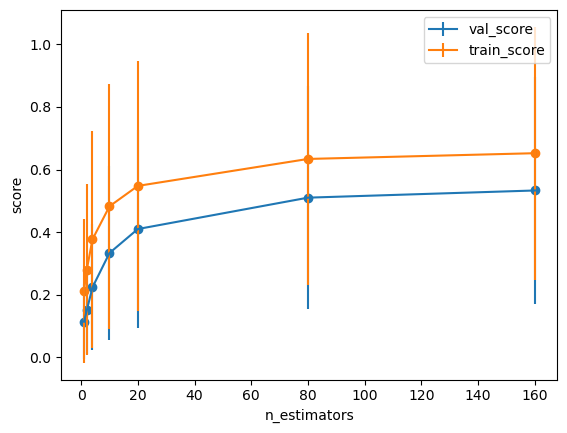

[0.11889196 0.13983109 0.20106898 0.27680034 0.31561882 0.35636402
 0.36299973]


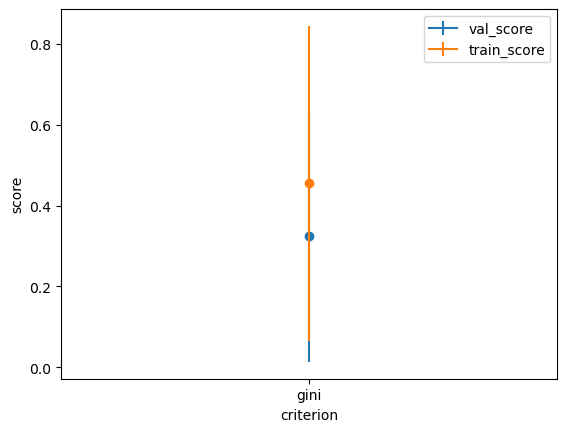

[0.31157595]


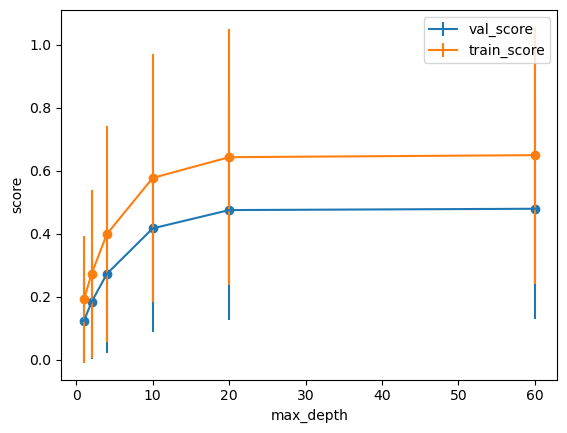

[0.12801043 0.18158559 0.25183838 0.3280696  0.34907422 0.34943478]


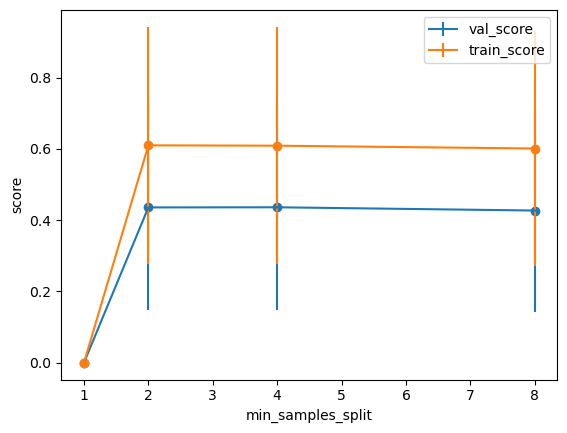

[0.         0.28881424 0.28882772 0.28413596]


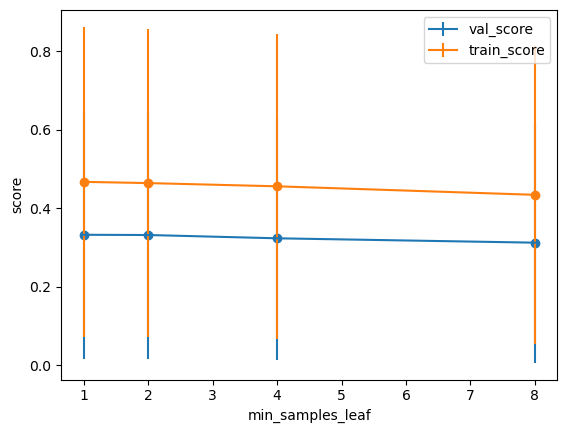

[0.31576684 0.31522621 0.30901918 0.30575259]


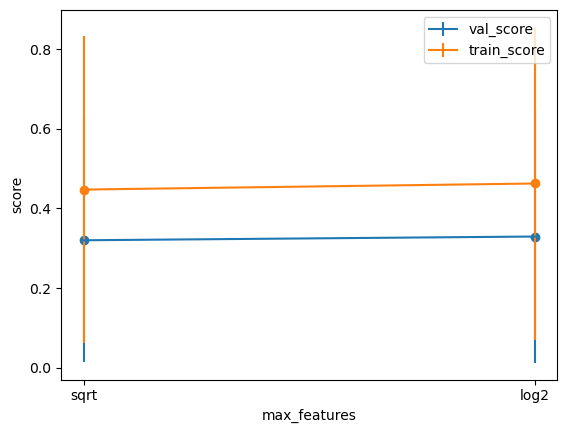

[0.30592986 0.31705182]


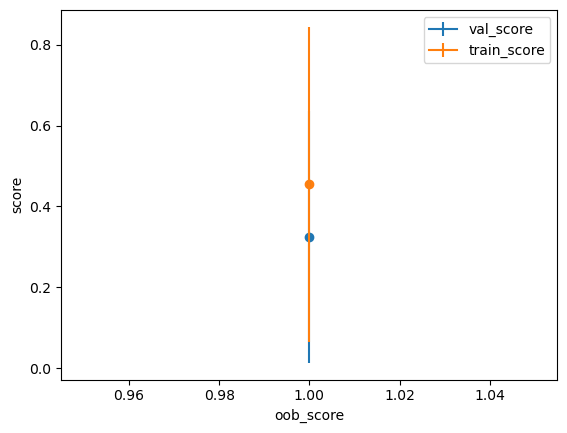

[0.31157595]


In [405]:
from math import nan

#Calculo la cantidad de configuraciones consideradas
n_configs = 0
for val_score, train_score, params in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
    n_configs = n_configs + 1

#key = 'max_depth'
for key in param_grid[0].keys():
    x_axis = param_grid[0][key]
    n_elems = int(n_configs/len(x_axis)) #nro de configuraciones que tienen el mismo valor de key. Es un entero
    val_axis = np.zeros([len(x_axis),n_elems])
    val_mean_axis = np.zeros(len(x_axis))
    val_std_axis = np.zeros(len(x_axis))
    train_axis = np.zeros([len(x_axis),n_elems])
    train_mean_axis = np.zeros(len(x_axis))
    train_std_axis = np.zeros(len(x_axis))

    #Recorro todas las configuraciones de parámetros
    for val_score, train_score, params in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
        #Recorro sobre las posibles configuraciones de key
        for i in range(len(x_axis)):
            #Si algún parámetro coincide con determinada configuración de key, lo tengo que considerar
            if(params[key] == x_axis[i]):
                #Recorro todos los valores ya guardados para cada configuración. Si alguno no es cero, escribo sobre ese punto y salgo del for.
                for j in range(n_elems):
                    if (val_axis[i,j] == 0):
                        val_axis[i,j] = val_score
                        break
                for j in range(n_elems):
                    if train_axis[i,j] == 0:
                        train_axis[i,j] = train_score
                        break
                #Elimino los nans:
                for j in range(n_elems):
                    if np.isnan(val_axis[i,j]):
                        val_axis[i,j] = 0
                        break
                for j in range(n_elems):
                    if np.isnan(train_axis[i,j]):
                        train_axis[i,j] = 0
                        break
                

    #Calculo el promedio y la desviación estándar

    for i in range(len(x_axis)):
        val_mean_axis[i] = np.mean(val_axis[i,:])
        val_std_axis[i] = np.std(val_axis[i,:])
        train_mean_axis[i] = np.mean(train_axis[i,:])
        train_std_axis[i] = np.std(train_axis[i,:])


    plt.errorbar(x_axis, val_mean_axis, val_std_axis, label = 'val_score')
    plt.scatter(x_axis, val_mean_axis)
    plt.errorbar(x_axis, train_mean_axis, train_std_axis, label = 'train_score')
    plt.scatter(x_axis, train_mean_axis)
    plt.legend()
    #Ejes
    plt.xlabel(key)
    plt.ylabel('score')
    plt.show()
    print(val_std_axis)

ESTARÍA BUENO HACER UN GRÁFICO SOLO PARA MAX DEPTH HASTA OVERFITTING

In [640]:
#Tengo que poner que me devuelva el error de test para cada entrenamiento del modelo

from sklearn.model_selection import GridSearchCV

#Defino los parámetros a variar:
n_stimators_list = [160]
criterion_list = ["gini"]  
max_depth_list = [1,2,4,10,20,60, 100, 150, 200, 400, 600, 800, 1000]
min_samples_split_list = [2]
min_samples_leaf_list = [2]
max_features_list = ["log2"]

param_grid = [
    {'n_estimators': n_stimators_list, 'criterion': criterion_list,  'max_depth': max_depth_list, 'min_samples_split':min_samples_split_list, 'min_samples_leaf':min_samples_leaf_list, 'max_features': max_features_list, 'oob_score':[True]},
  ]

# param_grid = [
#   {'n_estimators': [100], 'criterion':["entropy"],  'max_depth':[20, 40, 60, 100], 'min_samples_split':[2, 8], 'min_samples_leaf':[1, 4], 'max_features':["sqrt"], 'oob_score':[True]},
# ]

#Defino el modelo
RFmodel_GS = RandomForestClassifier(n_jobs = -1, random_state=42, oob_score = True)

grid_search = GridSearchCV(RFmodel_GS, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose = 3); #verbose muestra el progreso a medida que se hace el gridsearch. A mayor valor, más info da. El máximo es 3. Es útil cuando tengo que hacer corridas largas.
grid_search.fit(RFtrain_predictors, RFtrain_target)

from math import nan

#Calculo la cantidad de configuraciones consideradas
n_configs = 0
for val_score, train_score, params in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
    n_configs = n_configs + 1

cvres = grid_search.cv_results_


Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV 1/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True;, score=(train=0.582, test=0.375) total time=   2.3s
[CV 2/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True;, score=(train=0.570, test=0.438) total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True;, score=(train=0.633, test=0.469) total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True;, score=(train=0.582, test=0.406) total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=160, oob_score=True;, score=(train=0.555, test=0.359) total time=   0.2s

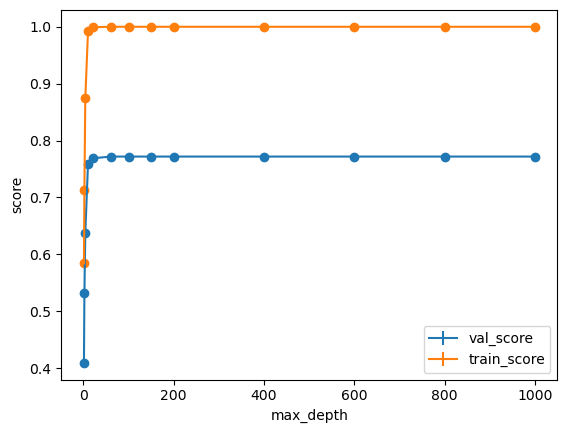

In [641]:
#Grafico:

#Calculo la cantidad de configuraciones consideradas
n_configs = 0
for val_score, train_score, params in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
    n_configs = n_configs + 1

key = 'max_depth'
x_axis = param_grid[0][key]
n_elems = int(n_configs/len(x_axis)) #nro de configuraciones que tienen el mismo valor de key. Es un entero
val_axis = np.zeros([len(x_axis),n_elems])
val_mean_axis = np.zeros(len(x_axis))
val_std_axis = np.zeros(len(x_axis))
train_axis = np.zeros([len(x_axis),n_elems])
train_mean_axis = np.zeros(len(x_axis))
train_std_axis = np.zeros(len(x_axis))


#Recorro todas las configuraciones de parámetros
for val_score, train_score, params in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
    #Recorro sobre las posibles configuraciones de key
    for i in range(len(x_axis)):
        #Si algún parámetro coincide con determinada configuración de key, lo tengo que considerar
        if(params[key] == x_axis[i]):
            #Recorro todos los valores ya guardados para cada configuración. Si alguno no es cero, escribo sobre ese punto y salgo del for.
            for j in range(n_elems):
                if (val_axis[i,j] == 0):
                    val_axis[i,j] = val_score
                    break
            for j in range(n_elems):
                if train_axis[i,j] == 0:
                    train_axis[i,j] = train_score
                    break

#Calculo el promedio y la desviación estándar

for i in range(len(x_axis)):
    val_mean_axis[i] = np.mean(val_axis[i,:])
    val_std_axis[i] = np.std(val_axis[i,:])
    train_mean_axis[i] = np.mean(train_axis[i,:])
    train_std_axis[i] = np.std(train_axis[i,:])


plt.errorbar(x_axis, val_mean_axis, val_std_axis, label = 'val_score')
plt.scatter(x_axis, val_mean_axis)
plt.errorbar(x_axis, train_mean_axis, train_std_axis, label = 'train_score')
plt.scatter(x_axis, train_mean_axis)
plt.legend()
plt.xlabel(key)
plt.ylabel('score')
plt.show()

##### Observaciones
El modelo overiftea para max_depth (complejidad) grande. Aún así val_score no disminuye. Esto se podría deber a la poca cantidad de datos.

#### Feature Importances
No se puede aplicar en este caso porque las features son los píxeles! Quizás halla "pixeles" más importantes que otros pero no lo sé


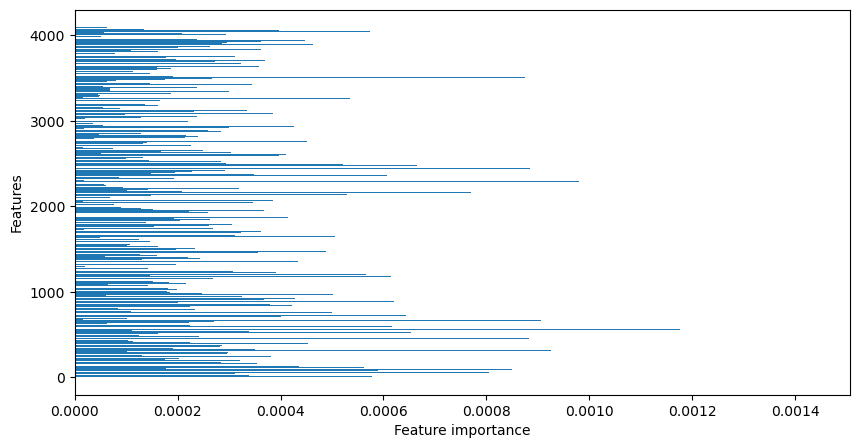

In [433]:
feature_importances = grid_search.best_estimator_.feature_importances_
#features = list(train_predictors.columns)
features = np.arange(64*64)

fig = plt.figure(figsize = (10, 5))
 
#Gráfico de barras
plt.barh(features, feature_importances)
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.show()


#### Best Random Forest model

In [431]:
#El mejor modelo de Random Forest es
# RFmodel_score = cross_val_score(grid_search.best_estimator_, RFtrain_predictors, RFtrain_target,scoring="accuracy", cv=5)
# display_scores(RFmodel_score)
RF_best_params = grid_search.best_estimator_.get_params()
RFmodel = RandomForestClassifier()
RFmodel.set_params(**RF_best_params);
RFmodel.fit(RFtrain_predictors, RFtrain_target)

RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=2,
                       n_estimators=160, n_jobs=-1, oob_score=True,
                       random_state=42)

In [409]:
#Calculo el accuracy sobre el set de train con el mejor modelo entrenado sobre los datos de train
import sklearn

sklearn.metrics.accuracy_score(RFtrain_target, RFmodel.predict(RFtrain_predictors))
#Overfitea

1.0

In [411]:
scores = cross_val_score(RFmodel, RFtrain_predictors, RFtrain_target,scoring="accuracy", cv=5) #cv es la cantidad de particiones
display_scores(scores)

Scores: [0.96875  0.953125 0.921875 0.9375   0.953125]
Mean: 0.946875
Standard deviation: 0.015934435979977454


### MODELO 2: DL

En primer lugar, se hará una separación entre train y test. En segundo lugar, se hará cross validation sobre dos modelos, uno simple y el otro idéntico pero sobre los datos obtenidos mediante data augmentation. Es importante destacar que no se puede usar la función CrossValidation de Scikit-learn. keras permite hacer validación sobre una parte del set de train pero no se puede hacer cross validation con varios splits. Por lo tanto, es necesario programarlo a mano. En tercer lugar, se realizará un grid search 

In [597]:
#Importo librerías
import tensorflow as tf
import keras

#### Separo entre Train y Test
Cargo datos. Para Random Forest bastó usar la imagen como input un array de 4096 elementos. Para redes convolucionales se emplea la imagen como una matriz de 64x64 con valores entre 0 y 1. Los datos dados en la sección 'images' del diccionario 'datos' ya se encuentran entre 0 y 1. Además, el output no puede tener el mismo formato que antes, hay que fabricar por cada categoría una columna y asignarle un 1 a la categoría que pertenezca determinada imagen, es decir, hay que hacer one hot encoding.

In [598]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(datos['images'], datos['target']):
    train_predictors, test_predictors = datos['images'][train_index], datos['images'][test_index]
    train_target, test_target = datos['target'][train_index], datos['target'][test_index]

#### Modelo simple inicial

In [ ]:
#Cargo datos
from keras.utils.np_utils import to_categorical
DLtrain_predictors = train_predictors.copy()
DLtrain_target = to_categorical(train_target, 40) #one-hot-encoding
DLtest_predictors = test_predictors.copy()
DLtest_target = to_categorical(train_target, 40) #one-hot-encoding

In [436]:
from functools import partial

#Defino algunos parámetros fijos de las layers convolucionales para no repetirlos continuamente:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

#Construyo la red neuronal
n_clases = 40
fig_size = 64

DLmodel = keras.models.Sequential([
    keras.layers.MaxPooling2D(pool_size=2, input_shape=[fig_size, fig_size, 1]),
    DefaultConv2D(filters=10, kernel_size=7),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=20),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=40),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=20, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=n_clases, activation='softmax'),
])

DLmodel.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])  
#Si uso CategoricalCrossEntropy el modelo espera que el target esté como one-hot encoding. Lo mismo ocurre con la métrica.

In [437]:
#DLmodel.fit(DLtrain_predictors, DLtrain_target, epochs=100, verbose = 2, validation_split = 0.2)
#el parámetro verbose = 2 muestra el progreso de cada epoch
#Se puede agregar " validation_data=(test_predictors, test_target)"

Epoch 1/100
8/8 - 2s - loss: 3.7007 - accuracy: 0.0117 - val_loss: 3.6908 - val_accuracy: 0.0625 - 2s/epoch - 230ms/step
Epoch 2/100
8/8 - 1s - loss: 3.6875 - accuracy: 0.0156 - val_loss: 3.6925 - val_accuracy: 0.0000e+00 - 515ms/epoch - 64ms/step
Epoch 3/100
8/8 - 1s - loss: 3.6879 - accuracy: 0.0273 - val_loss: 3.6950 - val_accuracy: 0.0000e+00 - 549ms/epoch - 69ms/step
Epoch 4/100
8/8 - 1s - loss: 3.6856 - accuracy: 0.0469 - val_loss: 3.6950 - val_accuracy: 0.0156 - 588ms/epoch - 73ms/step
Epoch 5/100
8/8 - 1s - loss: 3.6820 - accuracy: 0.0195 - val_loss: 3.7001 - val_accuracy: 0.0156 - 500ms/epoch - 63ms/step
Epoch 6/100
8/8 - 1s - loss: 3.6832 - accuracy: 0.0312 - val_loss: 3.6987 - val_accuracy: 0.0156 - 580ms/epoch - 72ms/step
Epoch 7/100
8/8 - 1s - loss: 3.6817 - accuracy: 0.0234 - val_loss: 3.7008 - val_accuracy: 0.0000e+00 - 635ms/epoch - 79ms/step
Epoch 8/100
8/8 - 1s - loss: 3.6792 - accuracy: 0.0508 - val_loss: 3.6951 - val_accuracy: 0.0156 - 644ms/epoch - 81ms/step
Epoch 

In [389]:
#Evaluamos el modelo (NO FUNCIONA)
#DLmodel.compute_metrics(DLtrain_predictors, DLtrain_target, DLmodel.predict(DLtrain_predictors), sample_weight=None)
#type(model.predict(train_predictors))

10/10 [==============================] - 0s 3ms/step


AttributeError: 'tuple' object has no attribute 'rank'

##### Cross Validation



In [599]:
from sklearn.model_selection import StratifiedKFold
cv_splits = 5
verbose_ = 0 #indica si se muestra el progreso de cada epoch sobre cada entrenamiento o no
cv_epochs = 1000 #nro de epochs por cada entrenamiento


#Crear modelo

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")


DLmodel = keras.models.Sequential([
keras.layers.MaxPooling2D(pool_size=2, input_shape=[64, 64, 1]),
DefaultConv2D(filters=10, kernel_size=7),
keras.layers.MaxPooling2D(pool_size=2),
DefaultConv2D(filters=20),
keras.layers.MaxPooling2D(pool_size=2),
DefaultConv2D(filters=40),
keras.layers.MaxPooling2D(pool_size=2),
keras.layers.Flatten(), #Convierte la matriz en un vector. Esto es necesario porque la capa densa no acepta matrices, sino arrays.
keras.layers.Dense(units=20, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Dense(units=n_clases, activation='softmax'),])

#Compilar modelo
DLmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])  

def DLCrossValidation(DLmodel, cv_splits, cv_epochs, verbose_, DLtrain_predictors, DLtrain_target, train_target):
    #Hace cross-validation sobre el modelo DLmodel, con cv_splits splits y cv_epochs epochs por cada split.
    #Retorna el accuracy de validación y de train de cada split.

    kfold = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    cv_valid_score = np.zeros(cv_splits)
    cv_train_score = np.zeros(cv_splits)

    contador = 0
    for train, test in kfold.split(DLtrain_predictors, train_target): #notese train_target no es DLtrain_target
        #Reporto qué modelo se está entrenando
        print("Entrenando modelo ", contador)
        contador = contador + 1

        #Fitear modelo: según entiendo estoy volviendo a fitear el modelo como si el anterior no existiera. Esto está "fundamentado" en https://stackoverflow.com/questions/49841324/what-does-calling-fit-multiple-times-on-the-same-model-do
        DLmodel.fit(DLtrain_predictors[train], DLtrain_target[train,:], epochs=cv_epochs, verbose = verbose_)
        #Evaluar modelo:
        scores_val = DLmodel.evaluate(DLtrain_predictors[test], DLtrain_target[test]) #scores es un array con el loss y el accuracy
        scores_train = DLmodel.evaluate(DLtrain_predictors[train], DLtrain_target[train]) #scores es un array con el loss y el accuracy
        #Guardar score:
        cv_valid_score[contador-1] = scores_val[1]
        cv_train_score[contador-1] = scores_train[1]
    return cv_valid_score, cv_train_score

cv_valid_score, cv_train_score = DLCrossValidation(DLmodel, cv_splits, cv_epochs, verbose_, DLtrain_predictors, DLtrain_target, train_target)


Entrenando modelo  0
8/8 [==============================] - 0s 7ms/step - loss: 0.2074 - accuracy: 1.0000
Entrenando modelo  1
8/8 [==============================] - 0s 7ms/step - loss: 0.1716 - accuracy: 1.0000
Entrenando modelo  2
8/8 [==============================] - 0s 6ms/step - loss: 0.1356 - accuracy: 1.0000
Entrenando modelo  3
8/8 [==============================] - 0s 8ms/step - loss: 0.1425 - accuracy: 0.9961
Entrenando modelo  4
8/8 [==============================] - 0s 32ms/step - loss: 0.1345 - accuracy: 1.0000


In [ ]:
#Se obtuvo:
# Entrenando modelo  0
# 2/2 [==============================] - 0s 16ms/step - loss: 2.0514 - accuracy: 0.7656
# 8/8 [==============================] - 0s 4ms/step - loss: 0.1207 - accuracy: 0.9922
# Entrenando modelo  1
# 2/2 [==============================] - 0s 16ms/step - loss: 0.3780 - accuracy: 0.9062
# 8/8 [==============================] - 0s 7ms/step - loss: 0.0481 - accuracy: 1.0000
# Entrenando modelo  2
# 2/2 [==============================] - 0s 16ms/step - loss: 0.1800 - accuracy: 0.9844
# 8/8 [==============================] - 0s 7ms/step - loss: 0.0549 - accuracy: 1.0000
# Entrenando modelo  3
# 2/2 [==============================] - 0s 7ms/step - loss: 0.1054 - accuracy: 0.9844
# 8/8 [==============================] - 0s 6ms/step - loss: 0.0478 - accuracy: 1.0000
# Entrenando modelo  4
# 2/2 [==============================] - 0s 6ms/step - loss: 0.1426 - accuracy: 0.9531
# 8/8 [==============================] - 0s 5ms/step - loss: 0.0474 - accuracy: 1.0000

In [439]:
#Calculo media de accuracy y desviación estándar
print("CV-validation-accuracy: ","%.2f +/- %.2f" % (np.mean(cv_valid_score), np.std(cv_valid_score)))
print("CV-train-accuracy: ","%.2f +/- %.2f" % (np.mean(cv_train_score), np.std(cv_train_score)))

CV-validation-accuracy:  0.92 +/- 0.08
CV-train-accuracy:  1.00 +/- 0.00


In [ ]:
#Se obtuvo:
# CV-validation-accuracy:  0.92 +/- 0.08
# CV-train-accuracy:  1.00 +/- 0.0

#### Grid Search

¿Qué parámetros hay presentes para variar?
* Parámetros de contrucción de la red (arquitectura). Aquí se encuentran, por ejemplo, la cantidad de layers convolucionales y pooling y su ordenamiento, la cantidad de mapas de activación en cada layer convolucional, el tipo de pooling (max, mean, etc....), la cantidad de layers densas al final de la red y su función de activación asociada, entre otras. Se decidió optar por una arquitectura fija, maxpooling (recomendación en Gerón) y dos capas densas al final con "relu" como función de activación (recomendación en Gerón). En cuanto a la arquitectura, se comenzará con una layer maxpooling de modo de disminuir el tamaño de la imagen de 64x64 a 32x32 y así poder facilitar la ejecución del modelo, para luego continuar con series de layers convolucional, pooling, convolucional, .... y así sucesivamente en una cantidad fija. Además, la cantidad de mapas de activación de cada layer convolucional será variable pero no arbitrariamente. Todas estarán relacionadas por un único parámetro: tal cantidad en la primer capa.

También sobre las layers convs: tamaño del kernel, tamaño del salto (...), función de activación, padding, dropout
* Parámetros del modelo
Se podría variar la función de loss, la métrica, loss weights (pesos de cada output en el cálculo de la loss)
Existen otros atributos pero están más relacionados con la performance del modelo
Se decidió variar el tamaño del kernel de las layers intermedias, la primera va a tener siempre 10. Se variará entre 3, 5 y 7. NO SE HARÁ ESTO POR CUESTIONES DE CÁLCULO
Se decidió variar la cantidad de mapas de activación
No se varía ningún parámetro que no sea de la arquitectura
epochs tmb se puede variar. Yo lo voy a mantener en 1000
Hacer padding o no

Explicar por qué hice el grid search a mano

In [440]:

def DLCreate_model(n_mp):
    #Crea el DLmodel considerando como inputs los parámetros que se van a variar en el gridsearch
    #n_mp: nro de mapas de activación de la primer capa convolucional. Los demás se calculan en función de este.

    #Defino algunos parámetros fijos de las layers convolucionales para no repetirlos continuamente
    DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

    #Creo el modelo
    DLmodel = keras.models.Sequential([
    keras.layers.MaxPooling2D(pool_size=2, input_shape=[64, 64, 1]),
    DefaultConv2D(filters=n_mp, kernel_size=10),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=2*n_mp),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=4*n_mp),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(), #Convierte la matriz en un vector. Esto es necesario porque la capa densa no acepta matrices, sino arrays.
    keras.layers.Dense(units=2*n_mp, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=n_clases, activation='softmax'),])

    #Compilar modelo
    DLmodel.compile(optimizer= "adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return DLmodel


In [441]:
n_mp_array = [5,10,20]
train_score = np.zeros(len(n_mp_array))
train_stdscore = np.zeros(len(n_mp_array))
valid_score = np.zeros(len(n_mp_array))
valid_stdscore = np.zeros(len(n_mp_array))


for n_mp in n_mp_array:
    DLmodel = DLCreate_model(n_mp)
    cv_valid_score, cv_train_score = DLCrossValidation(DLmodel, cv_splits, cv_epochs, verbose_, DLtrain_predictors, DLtrain_target, train_target)
    print("cv_valid_score: ", cv_valid_score)
    print("cv_train_score: ", cv_train_score)

    #Calculo media de accuracy y desviación estándar de train y valid
    train_score[n_mp_array.index(n_mp)] = np.mean(cv_train_score)
    train_stdscore[n_mp_array.index(n_mp)] = np.std(cv_train_score)
    valid_score[n_mp_array.index(n_mp)] = np.mean(cv_valid_score)
    valid_stdscore[n_mp_array.index(n_mp)] = np.std(cv_valid_score)


Entrenando modelo  0
8/8 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.9531
Entrenando modelo  1
8/8 [==============================] - 0s 9ms/step - loss: 0.6121 - accuracy: 0.9766
Entrenando modelo  2
8/8 [==============================] - 0s 5ms/step - loss: 0.7513 - accuracy: 0.9375
Entrenando modelo  3
8/8 [==============================] - 0s 7ms/step - loss: 0.6362 - accuracy: 0.9688
Entrenando modelo  4
8/8 [==============================] - 0s 6ms/step - loss: 0.6294 - accuracy: 0.9609
cv_valid_score:  [0.5625   0.859375 0.875    0.90625  0.9375  ]
cv_train_score:  [0.953125  0.9765625 0.9375    0.96875   0.9609375]
Entrenando modelo  0
8/8 [==============================] - 0s 8ms/step - loss: 1.0147 - accuracy: 0.9062
Entrenando modelo  1
8/8 [==============================] - 0s 8ms/step - loss: 1.0578 - accuracy: 0.8789
Entrenando modelo  2


KeyboardInterrupt: 

In [ ]:
#Para el primer modelo se obtuvo:
# cv_valid_score:  [0.5625   0.859375 0.875    0.90625  0.9375  ]
# cv_train_score:  [0.953125  0.9765625 0.9375    0.96875   0.9609375]

In [ ]:
#Grafico:
plt.errorbar(n_mp_array, train_score, yerr=train_stdscore, fmt='o', label='train')
plt.errorbar(n_mp_array, valid_score, yerr=valid_stdscore, fmt='o', label='valid')
plt.xlabel('n_mp')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Evaluación de test y exportación del modelo

In [ ]:
train_predictions = model.predict(train_predictors)
print(np.max(train_predictions[0]))
print(train_target)
#model.compute_metrics(train_predictors, to_categorical(train_target, 40), train_predictions, sample_weight=None)

10/10 [==============================] - 0s 7ms/step
0.74051195
[13  5  3 12 10 20 24 35 11 13  1  9 20 37  1 20 35 32 36 33 16 33 19  7
 23 33 10 36 19 13 15 22 34 12  8  0  8 34 32 28 34  6  3 31 21 21 38 13
  8 12 25 34  5 26 33 16  4 37 20 35 20  8  3  6  9 30  4 31 18  0 16  9
 25 37 18 38  1 10 39  5 31 24  7 28 14 32 33 25  3 31 39 32 10 30 18  9
  3  8  1 24 31  7 15 22 39 28  7 16 24 26 20 26 26 39  3 17 16 26 27 29
 30 14 32 38 25 36 38 21 36 34 30 19  2 28  9 29 27 16 13 14 38 24  0 28
 10  4 16 39 38 29 17 25  5  5  9  8  8  1 22 28 29 27 18 10 19 37  0  9
  2 25  0 24 33 26 29 17 26 22 25  1 27 32  4 12 35 10 35 31 35 30 25  3
 23 10 22 29 19  9 24 11  2  8 37 23 23  1 28 30 11  5 14 15 11  4  0 15
 28 16 17 17 36  2  7 14 27 11 22 32 33  2 33 14 18 18 39 13 15 36 34 17
  6 20  6 38  5 11 37 27 13 39 24 12  0 13 29  7  6 12 36 37 22 36 18 15
 23  7 23 19  6 26 11 17 17 32  2 21  4  1  3 30 21  4 21 30 12 34 19 15
 18 35 14 38 21  7  6 27 35  2 15 31 20 31 23 14 23 39 11 22

Ver en qué se está equivocando. Capaz siempre es el mismo tipo de cara!